# Imports and setup

In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


        Use @ instead. [gala.coordinates.sgr]
        Use @ instead. [gala.coordinates.orphan]
        Use @ instead. [gala.coordinates.magellanic_stream]
I0000 00:00:1708466902.781675       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [3]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [4]:
data = at.Table.read("../../CATS_Workshop/cats/data/joined-GD-1.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

In [5]:
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

stream='GD-1'

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=3)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

A new version of galpy (1.9.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


        Use @ instead. [gala.coordinates.greatcircle]


-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -13.031354268696703, -3.10816045358226
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-13.279664008936617, -3.1651660299157447, 0.39918175447779325, 0.5336447547861582] 

Producing the polygon and mask


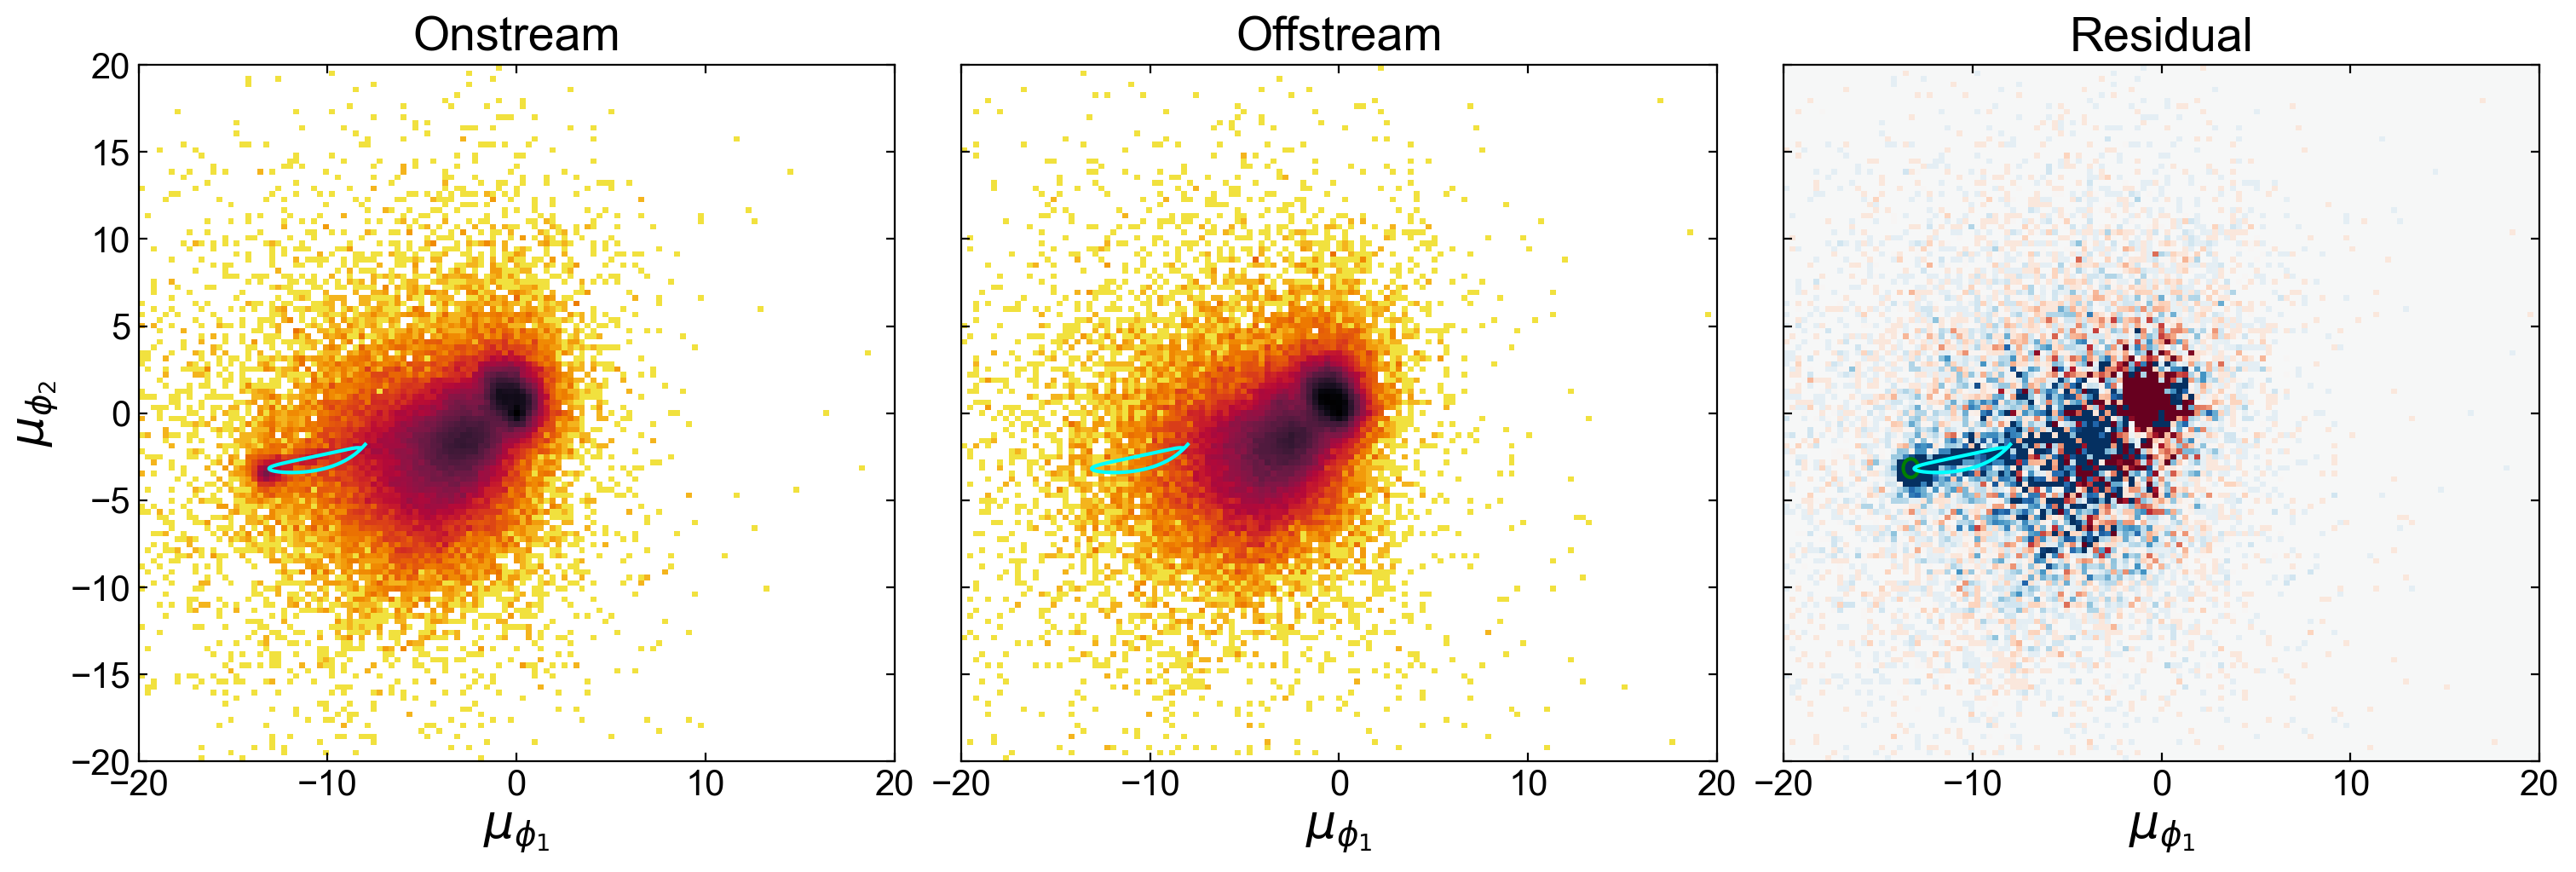

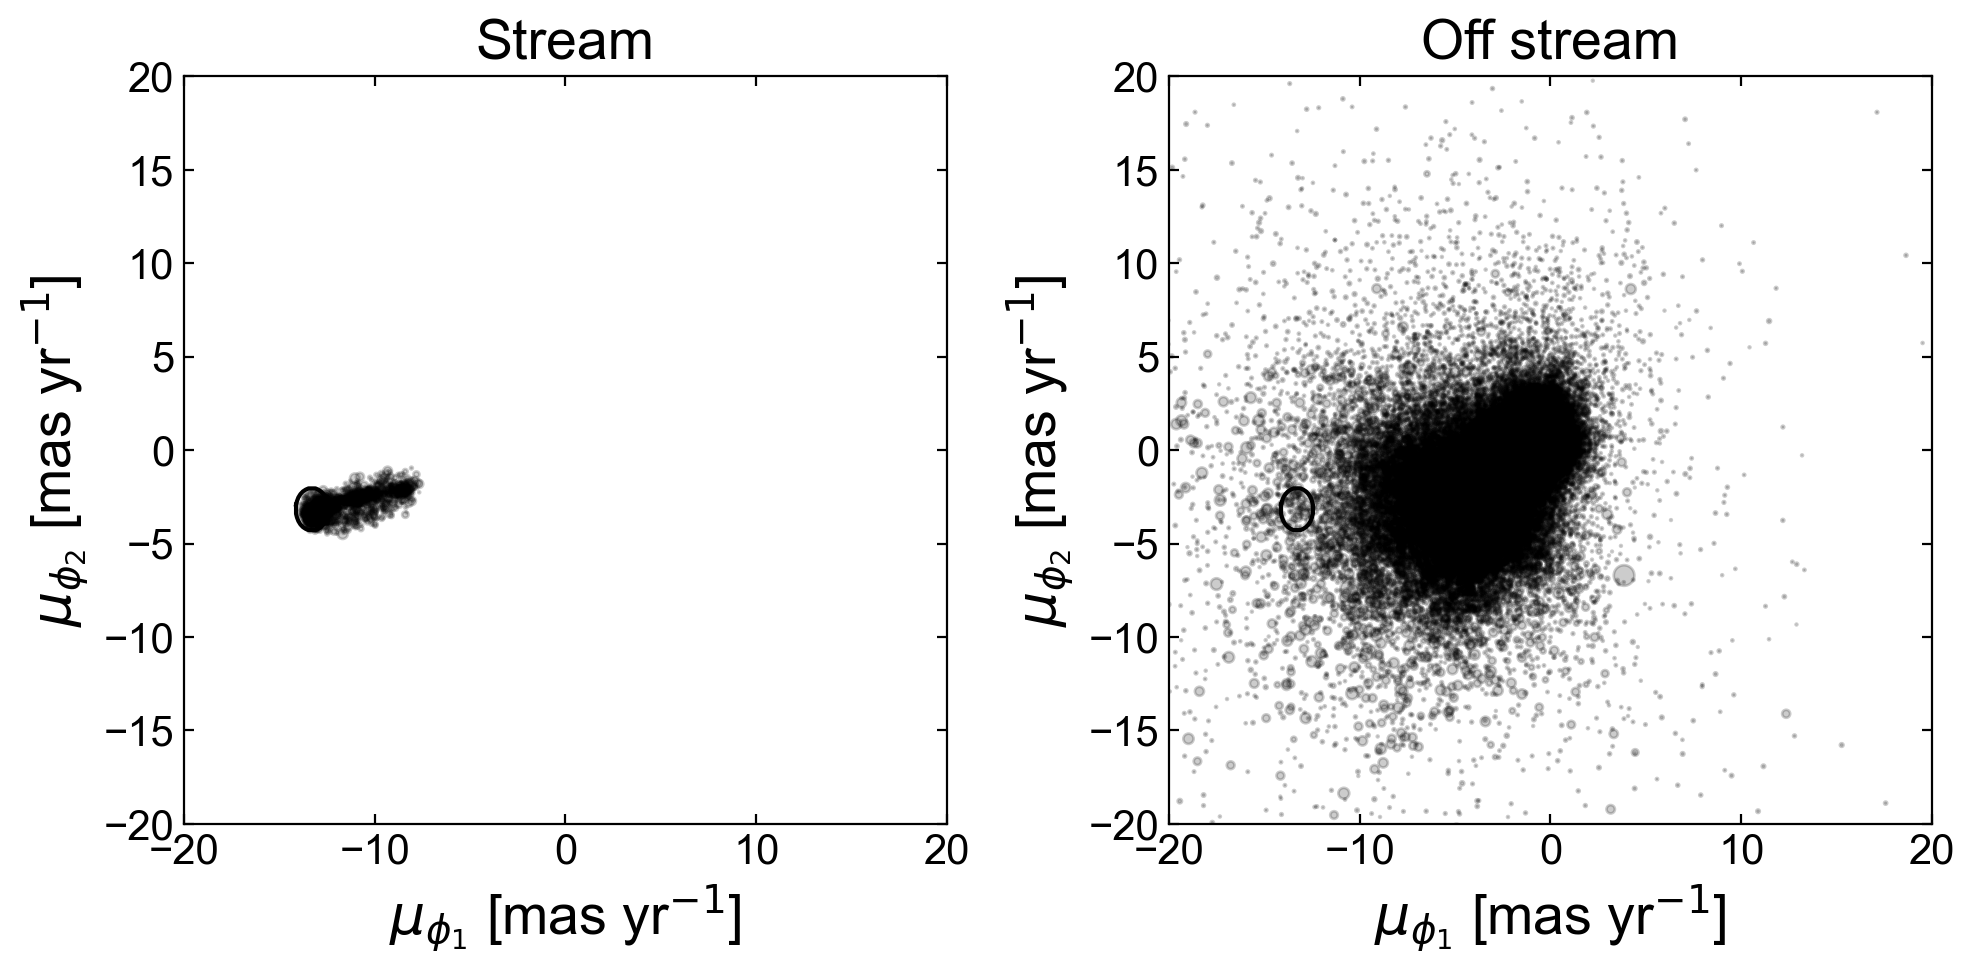

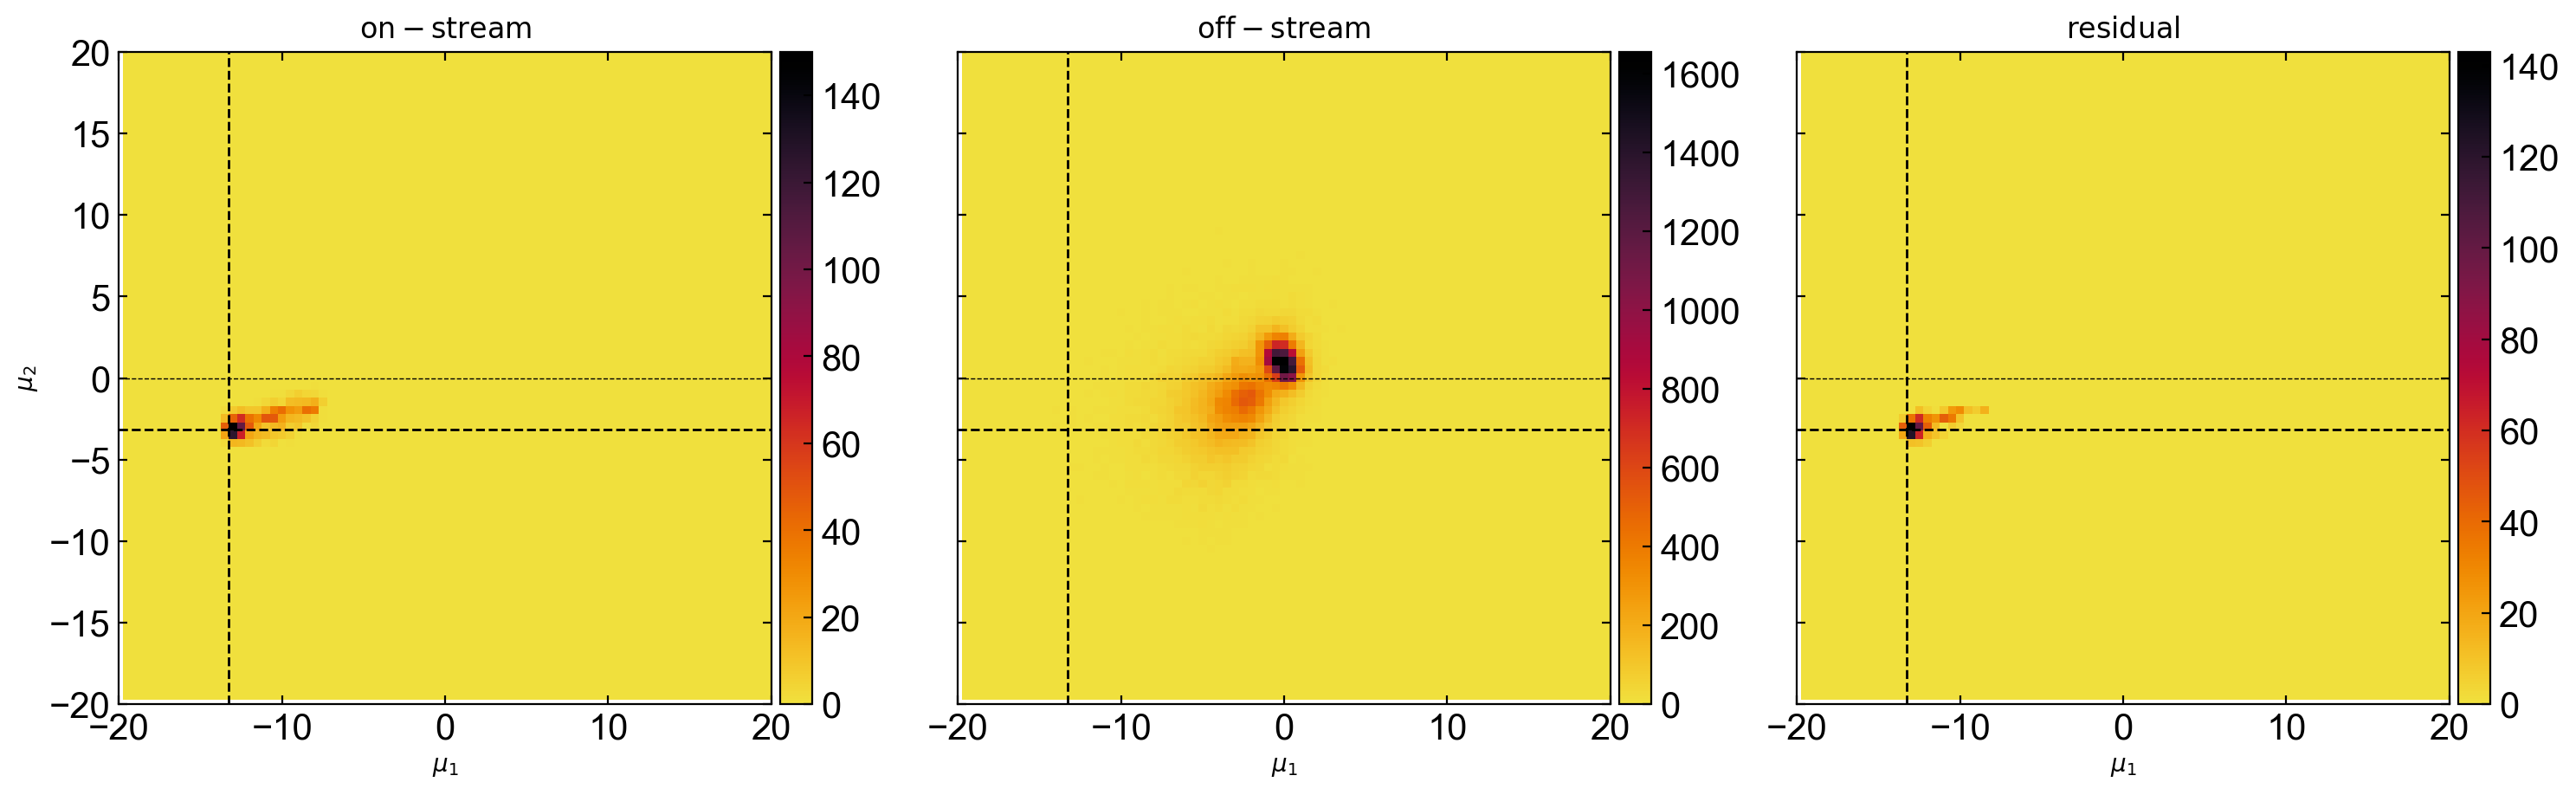

In [6]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [7]:
##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

        Use @ instead. [gala.coordinates.greatcircle]


In [8]:
Base.setup(p, cat)


((-99.99999968177843, 19.999977507814812),
 {'phi1': (-99.99999968177843, 19.999977507814812),
  'phi2': (-7.970665258306633, 3.3488445561550395),
  'pm1': (-15.099960783639155, -6.0100168343050075),
  'pm2': (-5.4174385931079785, 0.19860289156310484)},
 {'phi1': array([-9.99999997e+01, -9.97999997e+01, -9.95999997e+01, -9.93999997e+01,
         -9.91999997e+01, -9.89999997e+01, -9.87999997e+01, -9.85999997e+01,
         -9.83999997e+01, -9.81999997e+01, -9.79999997e+01, -9.77999997e+01,
         -9.75999997e+01, -9.73999997e+01, -9.71999997e+01, -9.69999997e+01,
         -9.67999997e+01, -9.65999997e+01, -9.63999997e+01, -9.61999997e+01,
         -9.59999997e+01, -9.57999997e+01, -9.55999997e+01, -9.53999997e+01,
         -9.51999997e+01, -9.49999997e+01, -9.47999997e+01, -9.45999997e+01,
         -9.43999997e+01, -9.41999997e+01, -9.39999997e+01, -9.37999997e+01,
         -9.35999997e+01, -9.33999997e+01, -9.31999997e+01, -9.29999997e+01,
         -9.27999997e+01, -9.25999997e+01, -9

In [9]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [10]:
len(bkg_data['phi1'])

34177

In [11]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

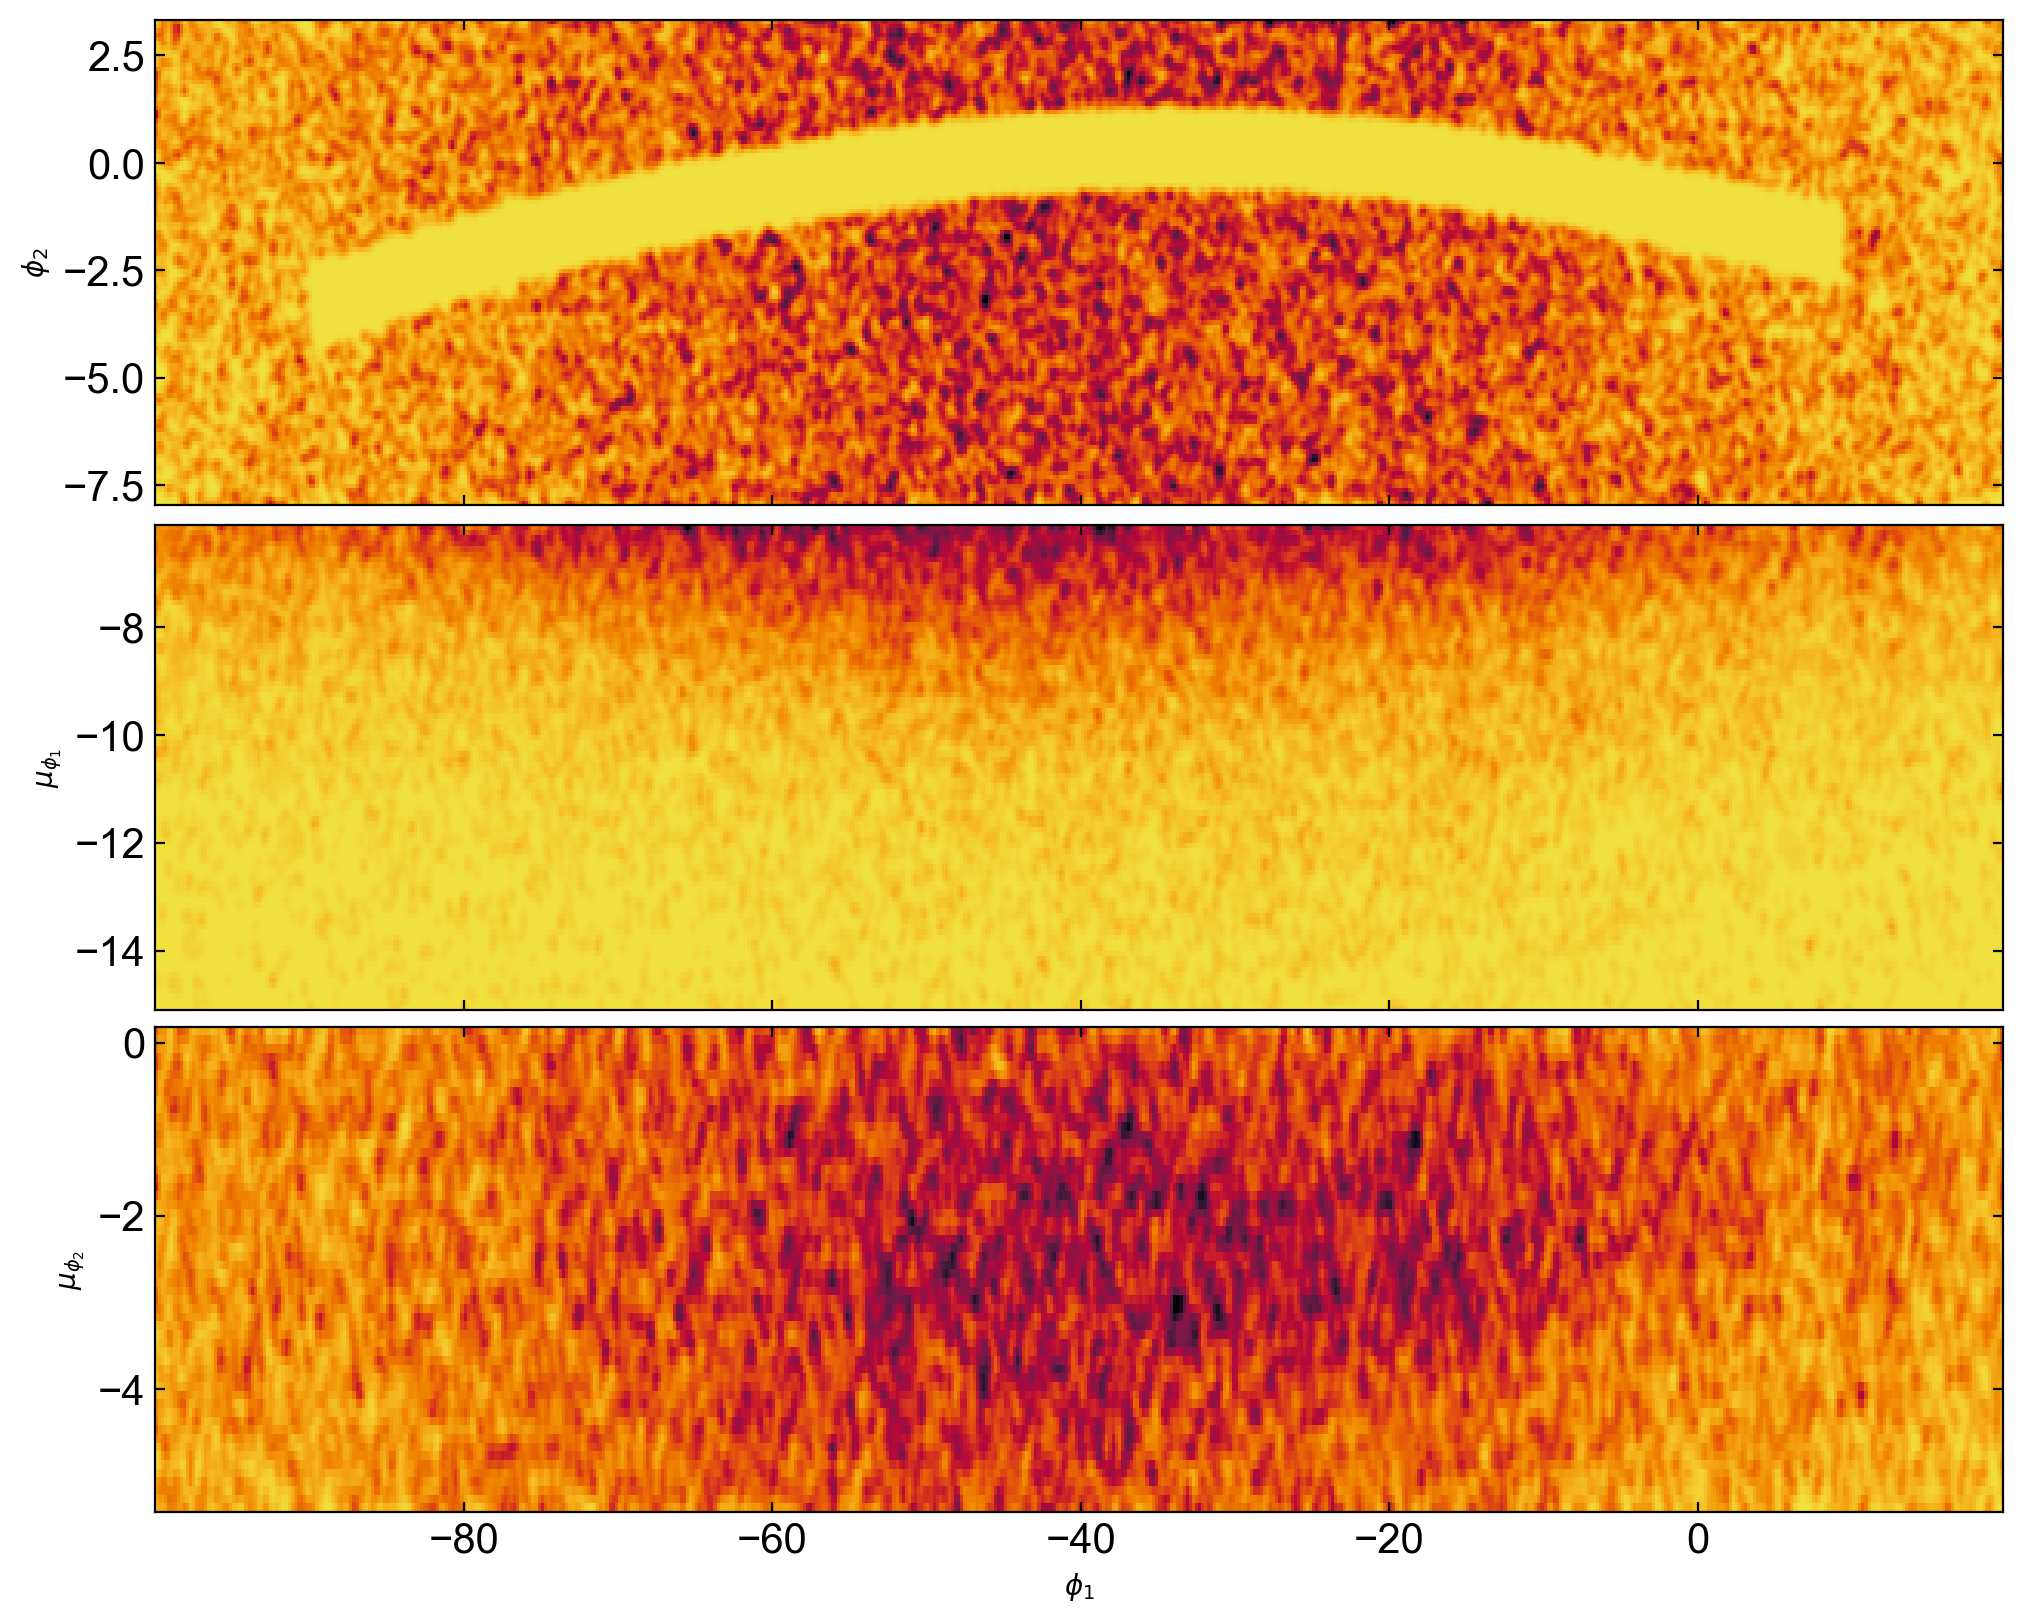

In [12]:
plot_data_projections(data=bkg_data, grids=Base.default_grids,
                      smooth=1);

# Background

In [13]:
BackgroundModel.bkg_update(p, cat)

In [14]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    #"phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    "phi1": {'zs': np.zeros(BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm1_knots, 0),
        "ln_std1": np.full_like(BackgroundModel.pm1_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm1_knots, 5),
        "ln_std2": np.full_like(BackgroundModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm2_knots, -2.),
        "ln_std1": np.full_like(BackgroundModel.pm2_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm2_knots, -3),
        "ln_std2": np.full_like(BackgroundModel.pm2_knots, 2)
    },
}

background_init = BackgroundModel(bkg_init_p)

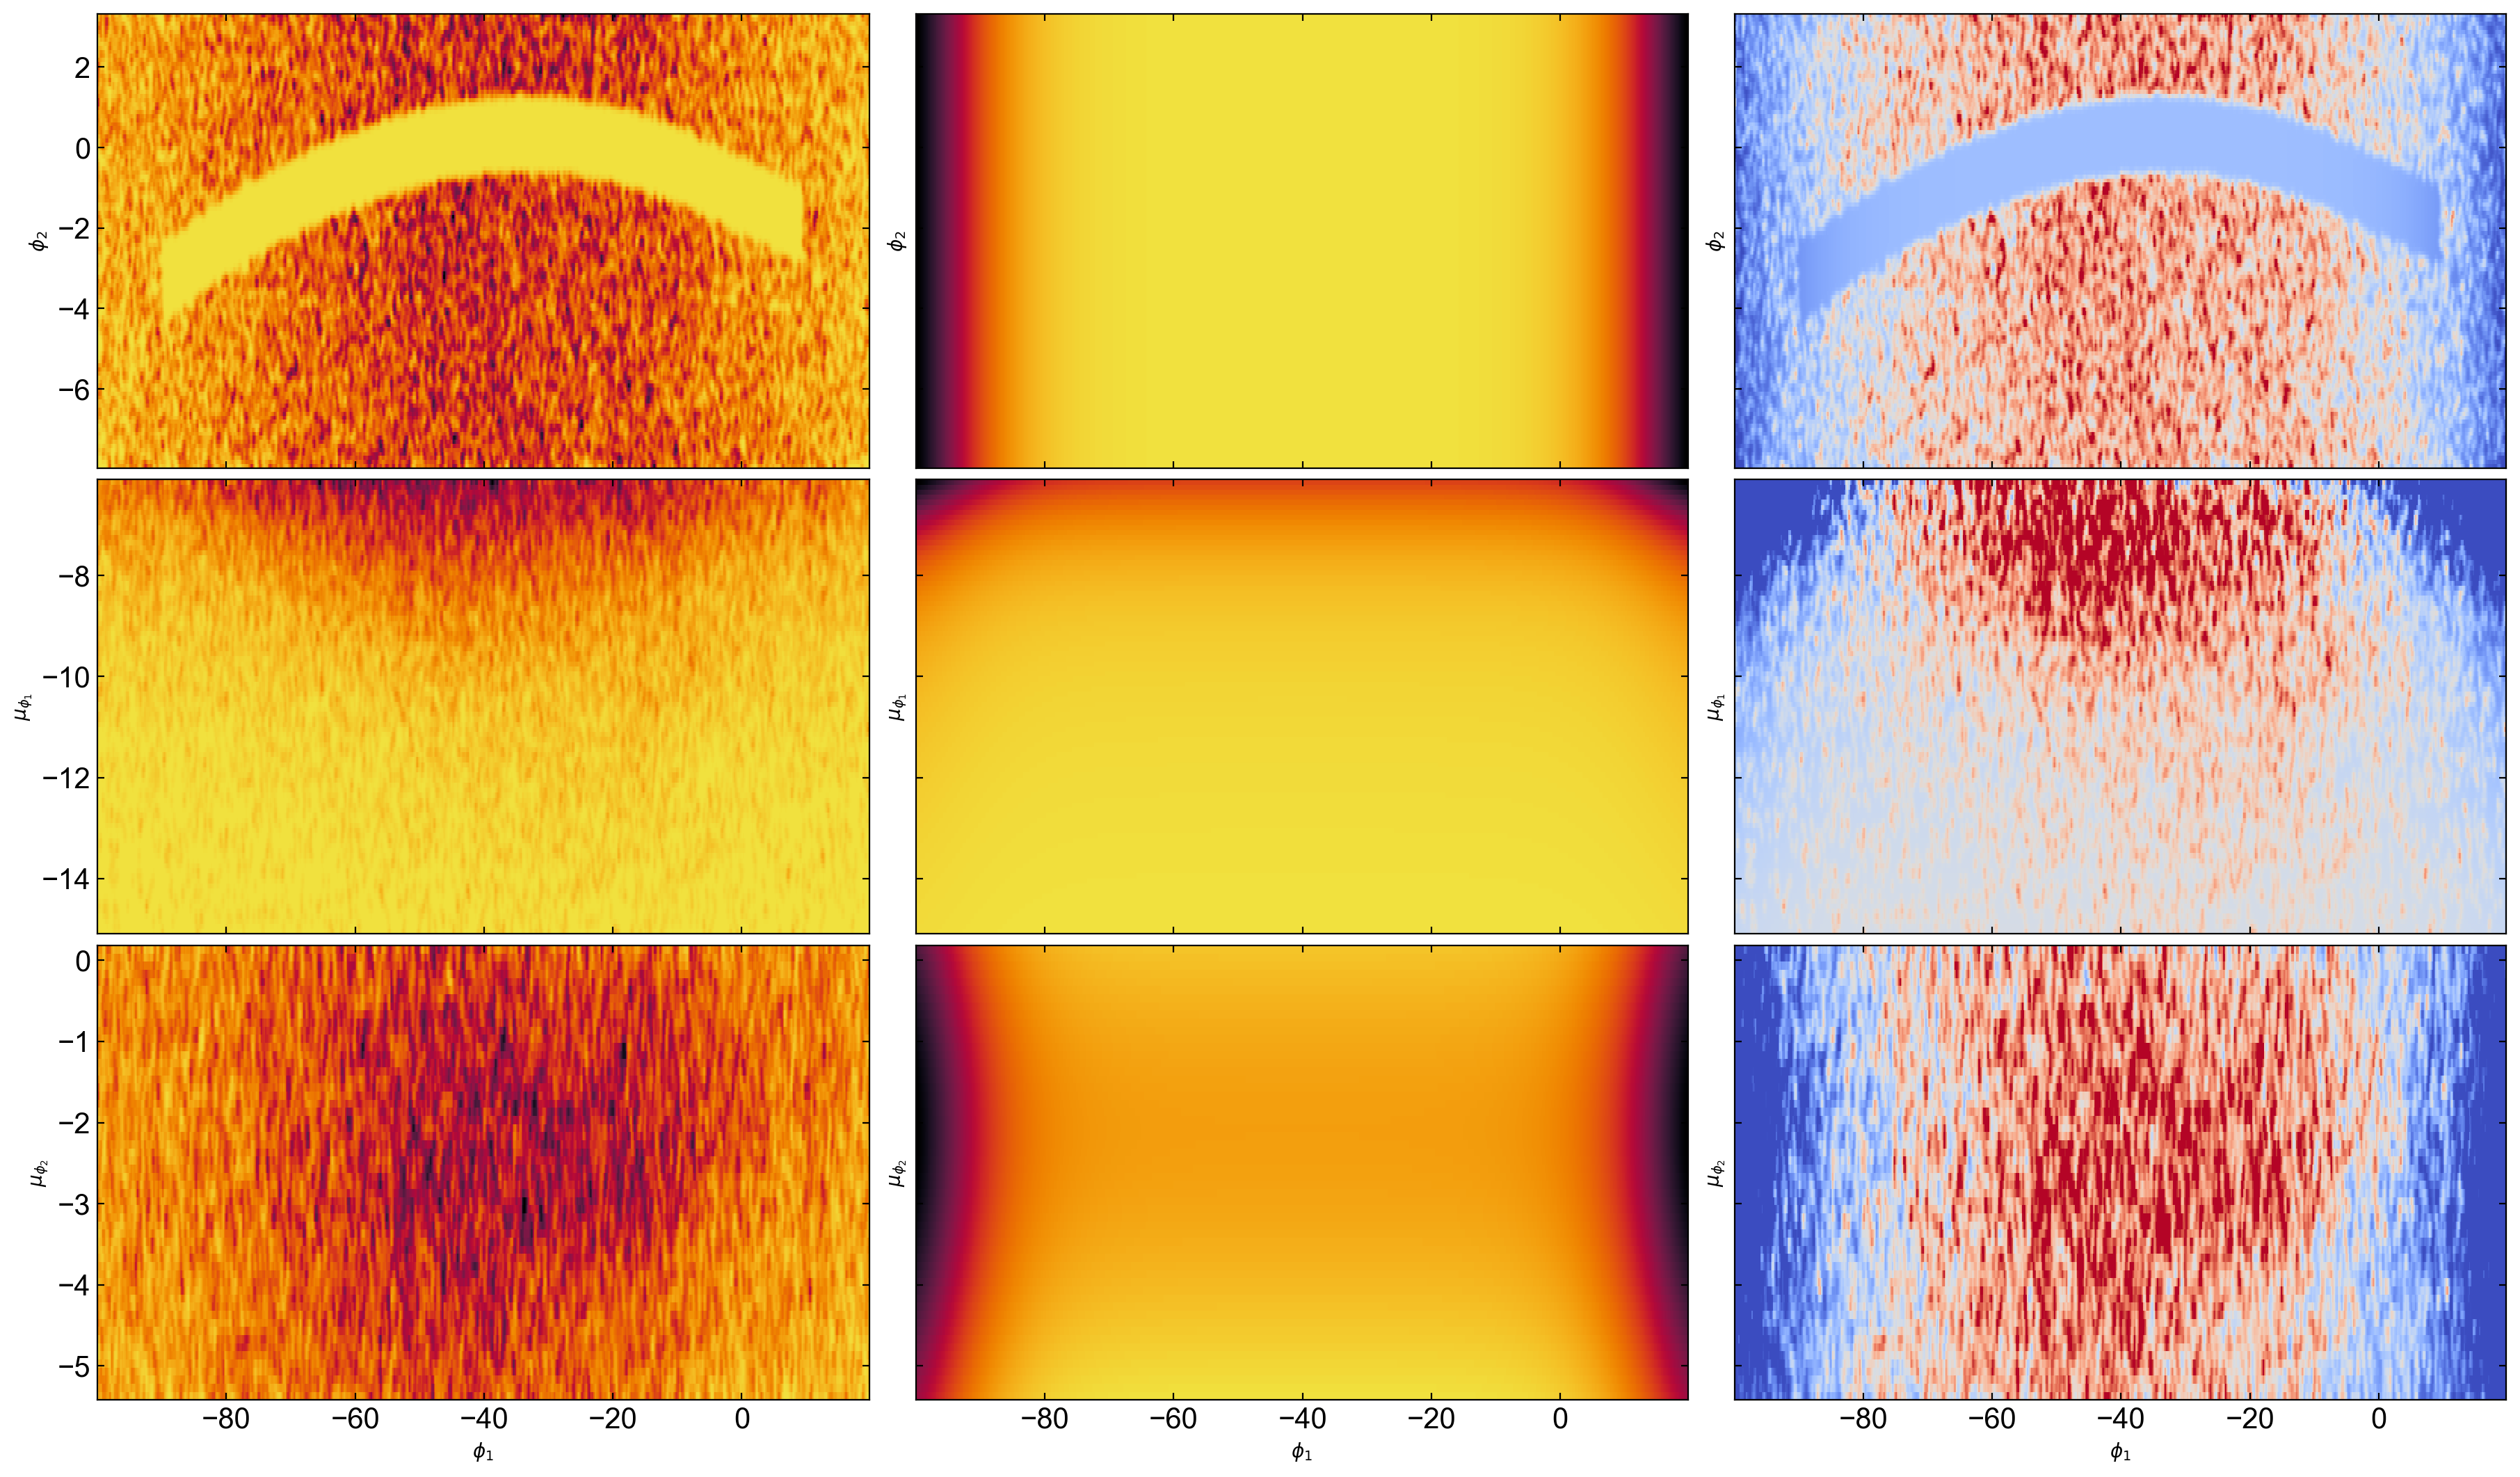

In [15]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=background_init.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

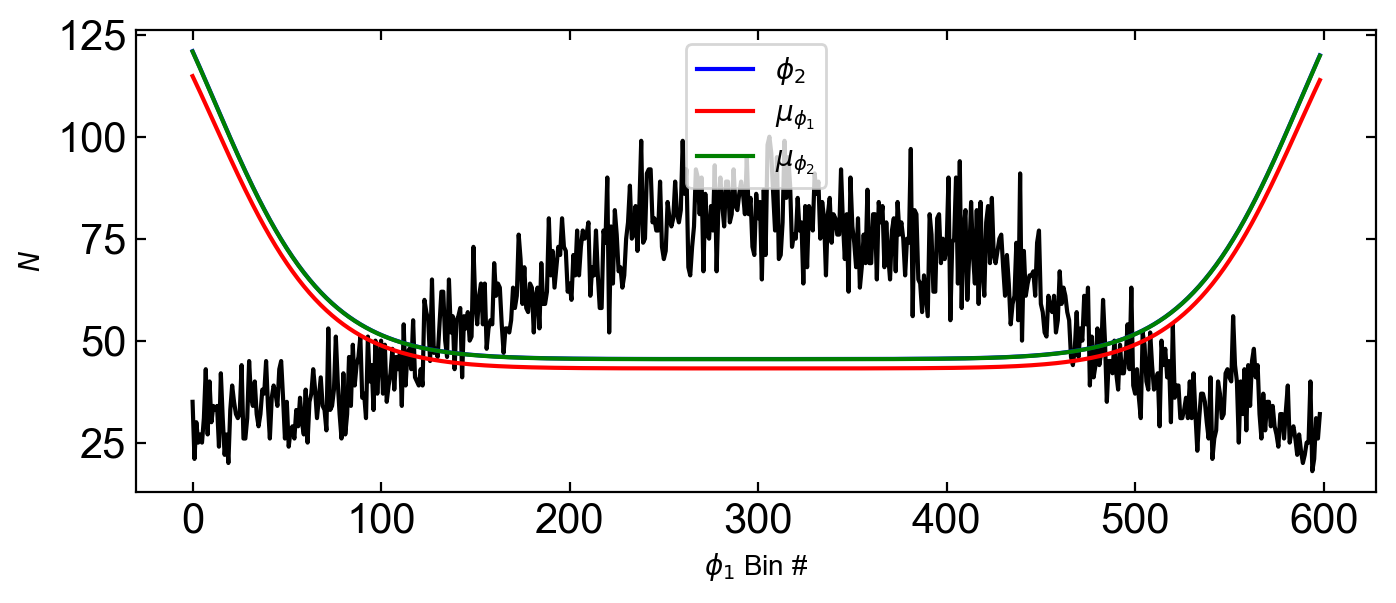

In [16]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [17]:
def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
    optimize_kwargs["bounds"] = (
        cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
        cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
    opt_res = optimizer.run(
        init_params=cls._normalize_variable_keys(init_params),
        data=cls._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    return cls._expand_variable_keys(opt_res.params), opt_res.state

In [18]:
# bkg_opt_pars, bkg_info = BackgroundModel.optimize(
#     data=bkg_data,
#     init_params=bkg_init_p,
#     use_bounds=True,
#     jaxopt_kwargs=dict(maxiter=4096),
# )

bkg_opt_pars, bkg_info = optimize(BackgroundModel,
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)


background_opt = BackgroundModel(bkg_opt_pars)
bkg_info

LbfgsbState(iter_num=Array(14, dtype=int64, weak_type=True), value=Array(1.15938217, dtype=float64), grad={'ln_N': Array(0.00089033, dtype=float64), 'phi1': {'zs': Array([ 1.98290079e-04,  6.55389701e-05, -2.23394886e-05, -7.82413828e-05,
       -3.24060827e-04, -3.87139206e-04, -1.67627538e-04,  3.47679922e-04,
        2.71611928e-04, -1.54807939e-04,  2.58322147e-04,  1.35601384e-04,
       -3.07795733e-04, -2.27003890e-04], dtype=float64)}, 'phi2': {}, 'pm1': {'ln_std1': Array([-3.28580015e-05,  9.81917653e-05, -4.10313809e-05, -7.43200300e-05,
       -1.51968284e-04,  3.38986042e-05, -5.44610255e-05, -6.73980889e-05,
       -2.82433783e-05,  1.59597254e-04,  1.48769212e-04,  1.16771896e-04,
       -1.15545622e-04], dtype=float64), 'ln_std2': Array([ 6.60549692e-06, -7.76748298e-05, -5.64488329e-05,  7.02815702e-06,
       -4.20134590e-05, -1.31073849e-04,  3.43471996e-06,  3.04123885e-05,
        7.43946594e-05,  6.65308177e-05, -2.41709046e-05, -6.35884936e-05,
        2.31882434e

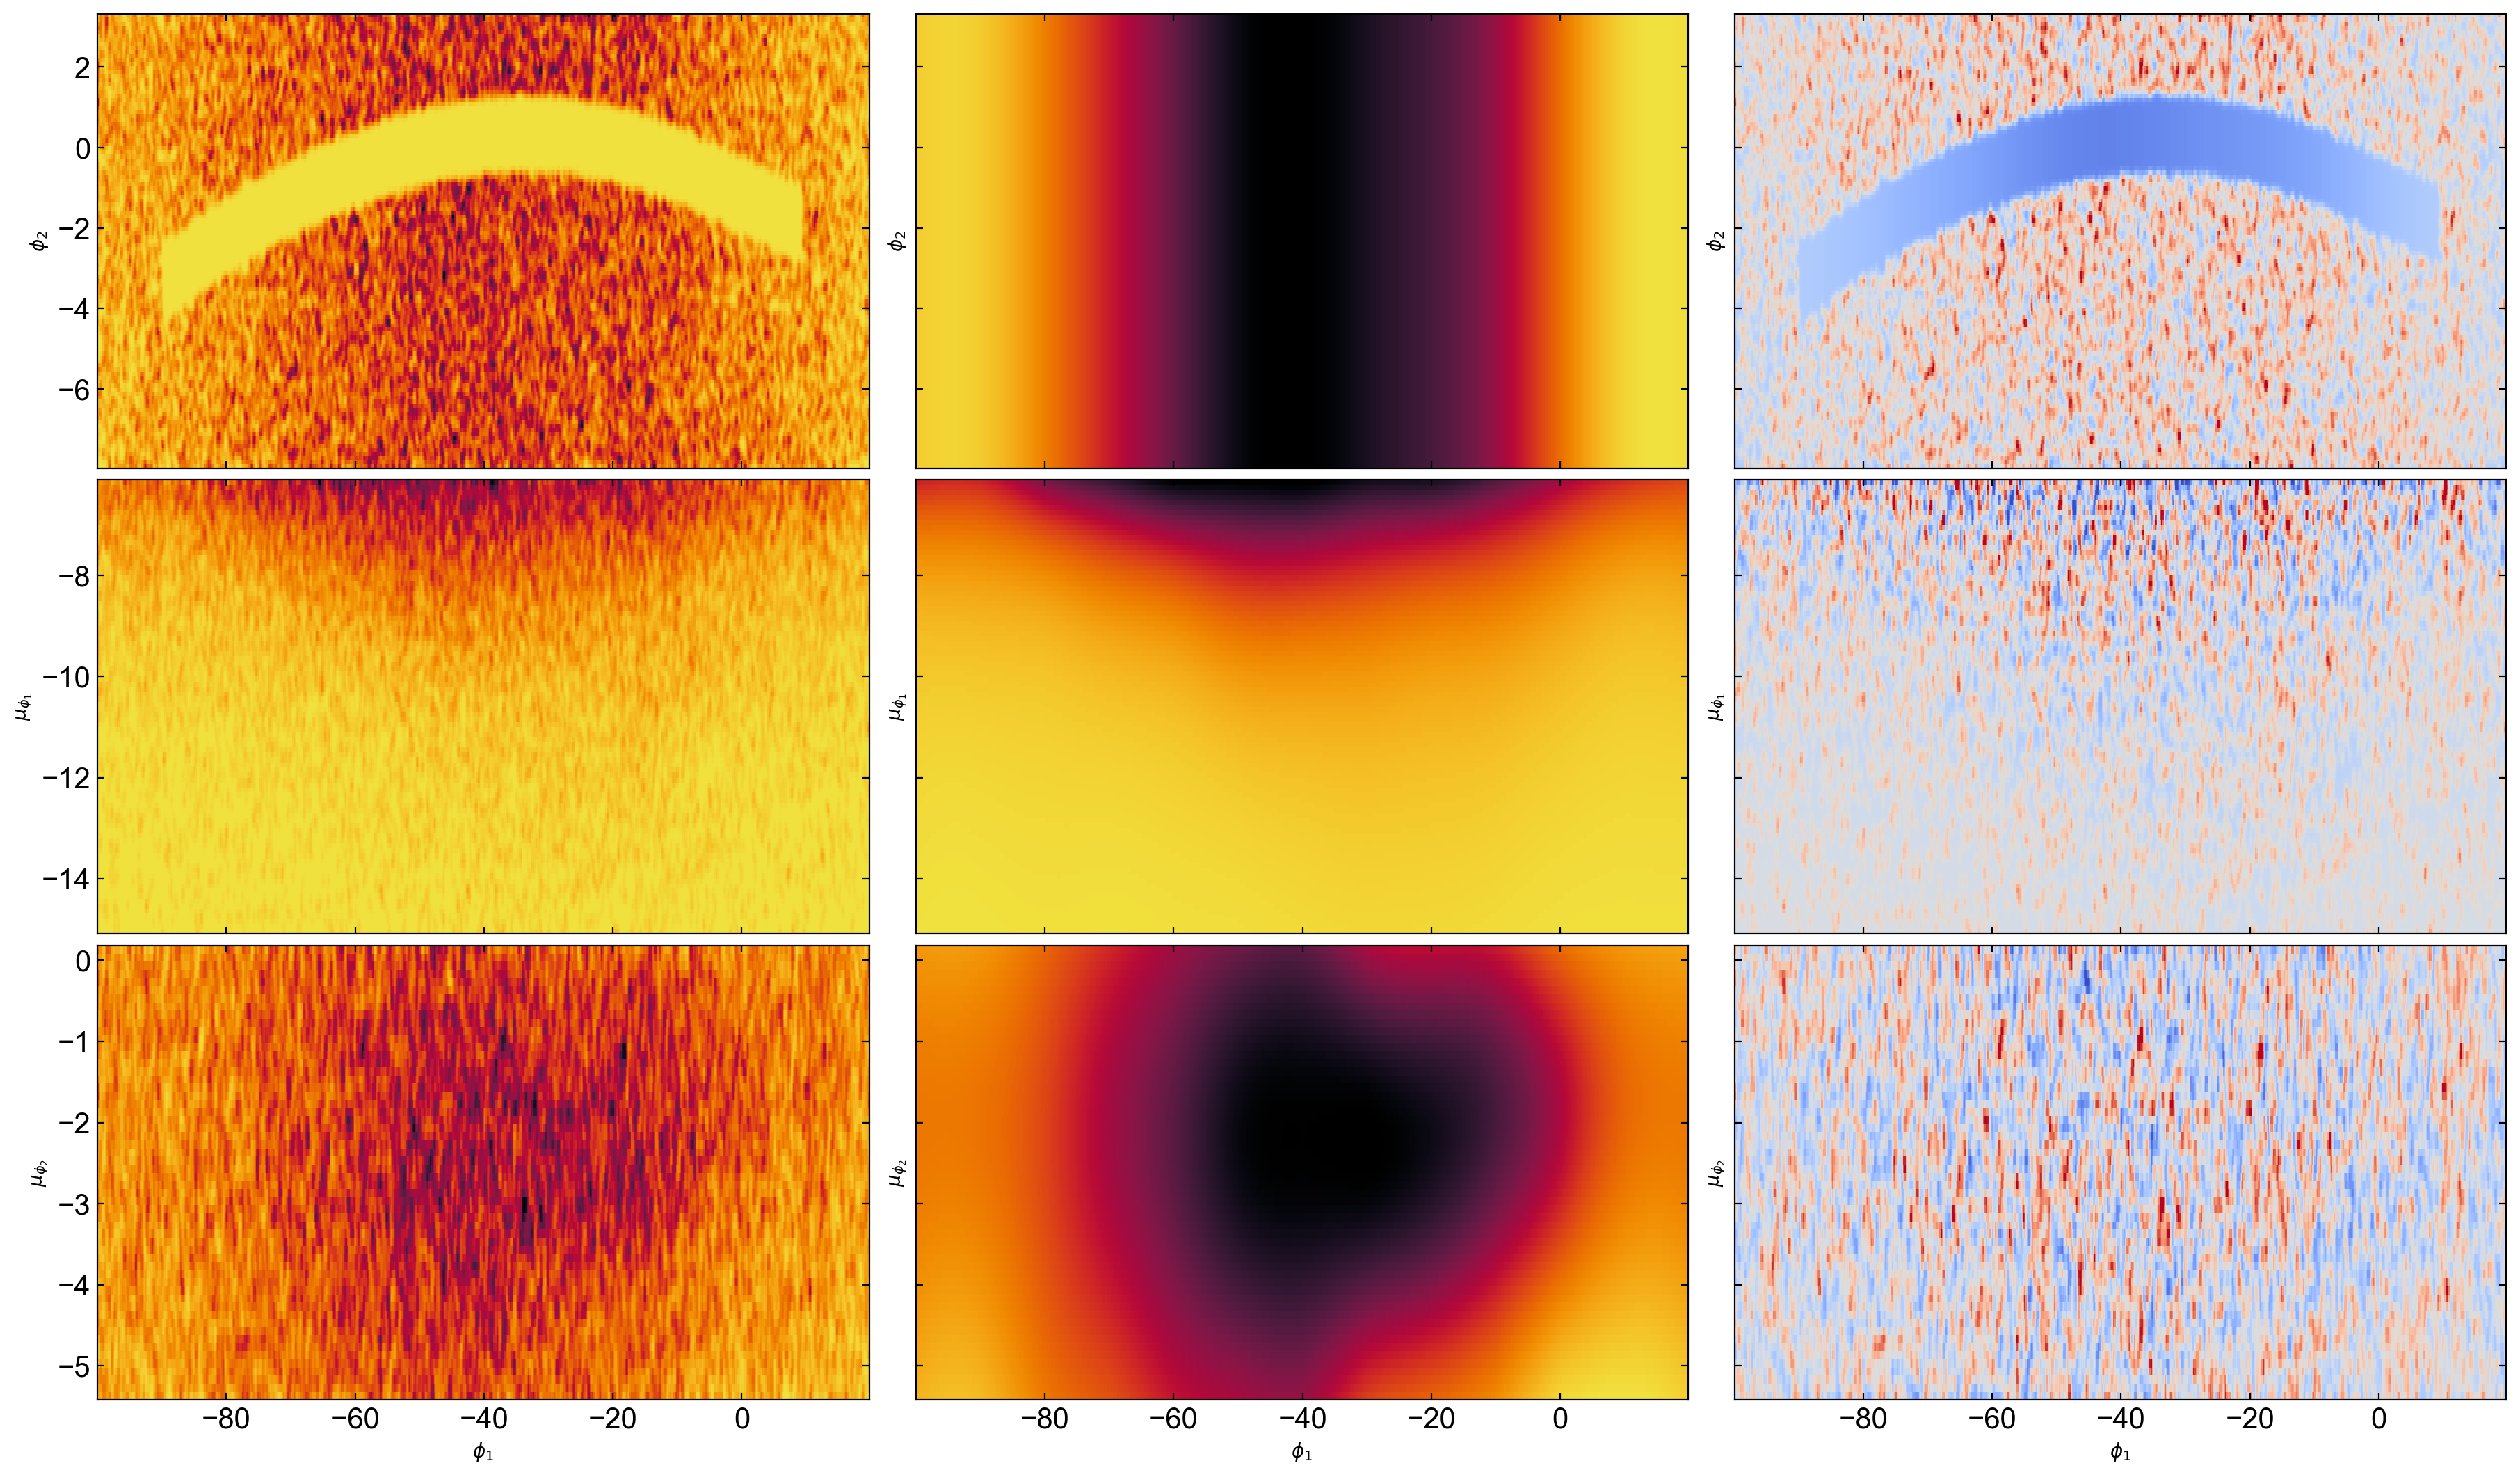

In [19]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")
fig.savefig('test_residual.png')

# Stream

In [20]:
StreamDensModel.stream_dens_update(p, cat)

In [21]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-90, 10, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [22]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

        Use @ instead. [gala.coordinates.greatcircle]


In [23]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(StreamDensModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(StreamDensModel.phi2_knots),
        "ln_std": np.full_like(StreamDensModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(StreamDensModel.pm1_knots),
        "ln_std": np.full_like(StreamDensModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(StreamDensModel.pm2_knots),
        "ln_std": np.full_like(StreamDensModel.pm2_knots, -1)
    }
}

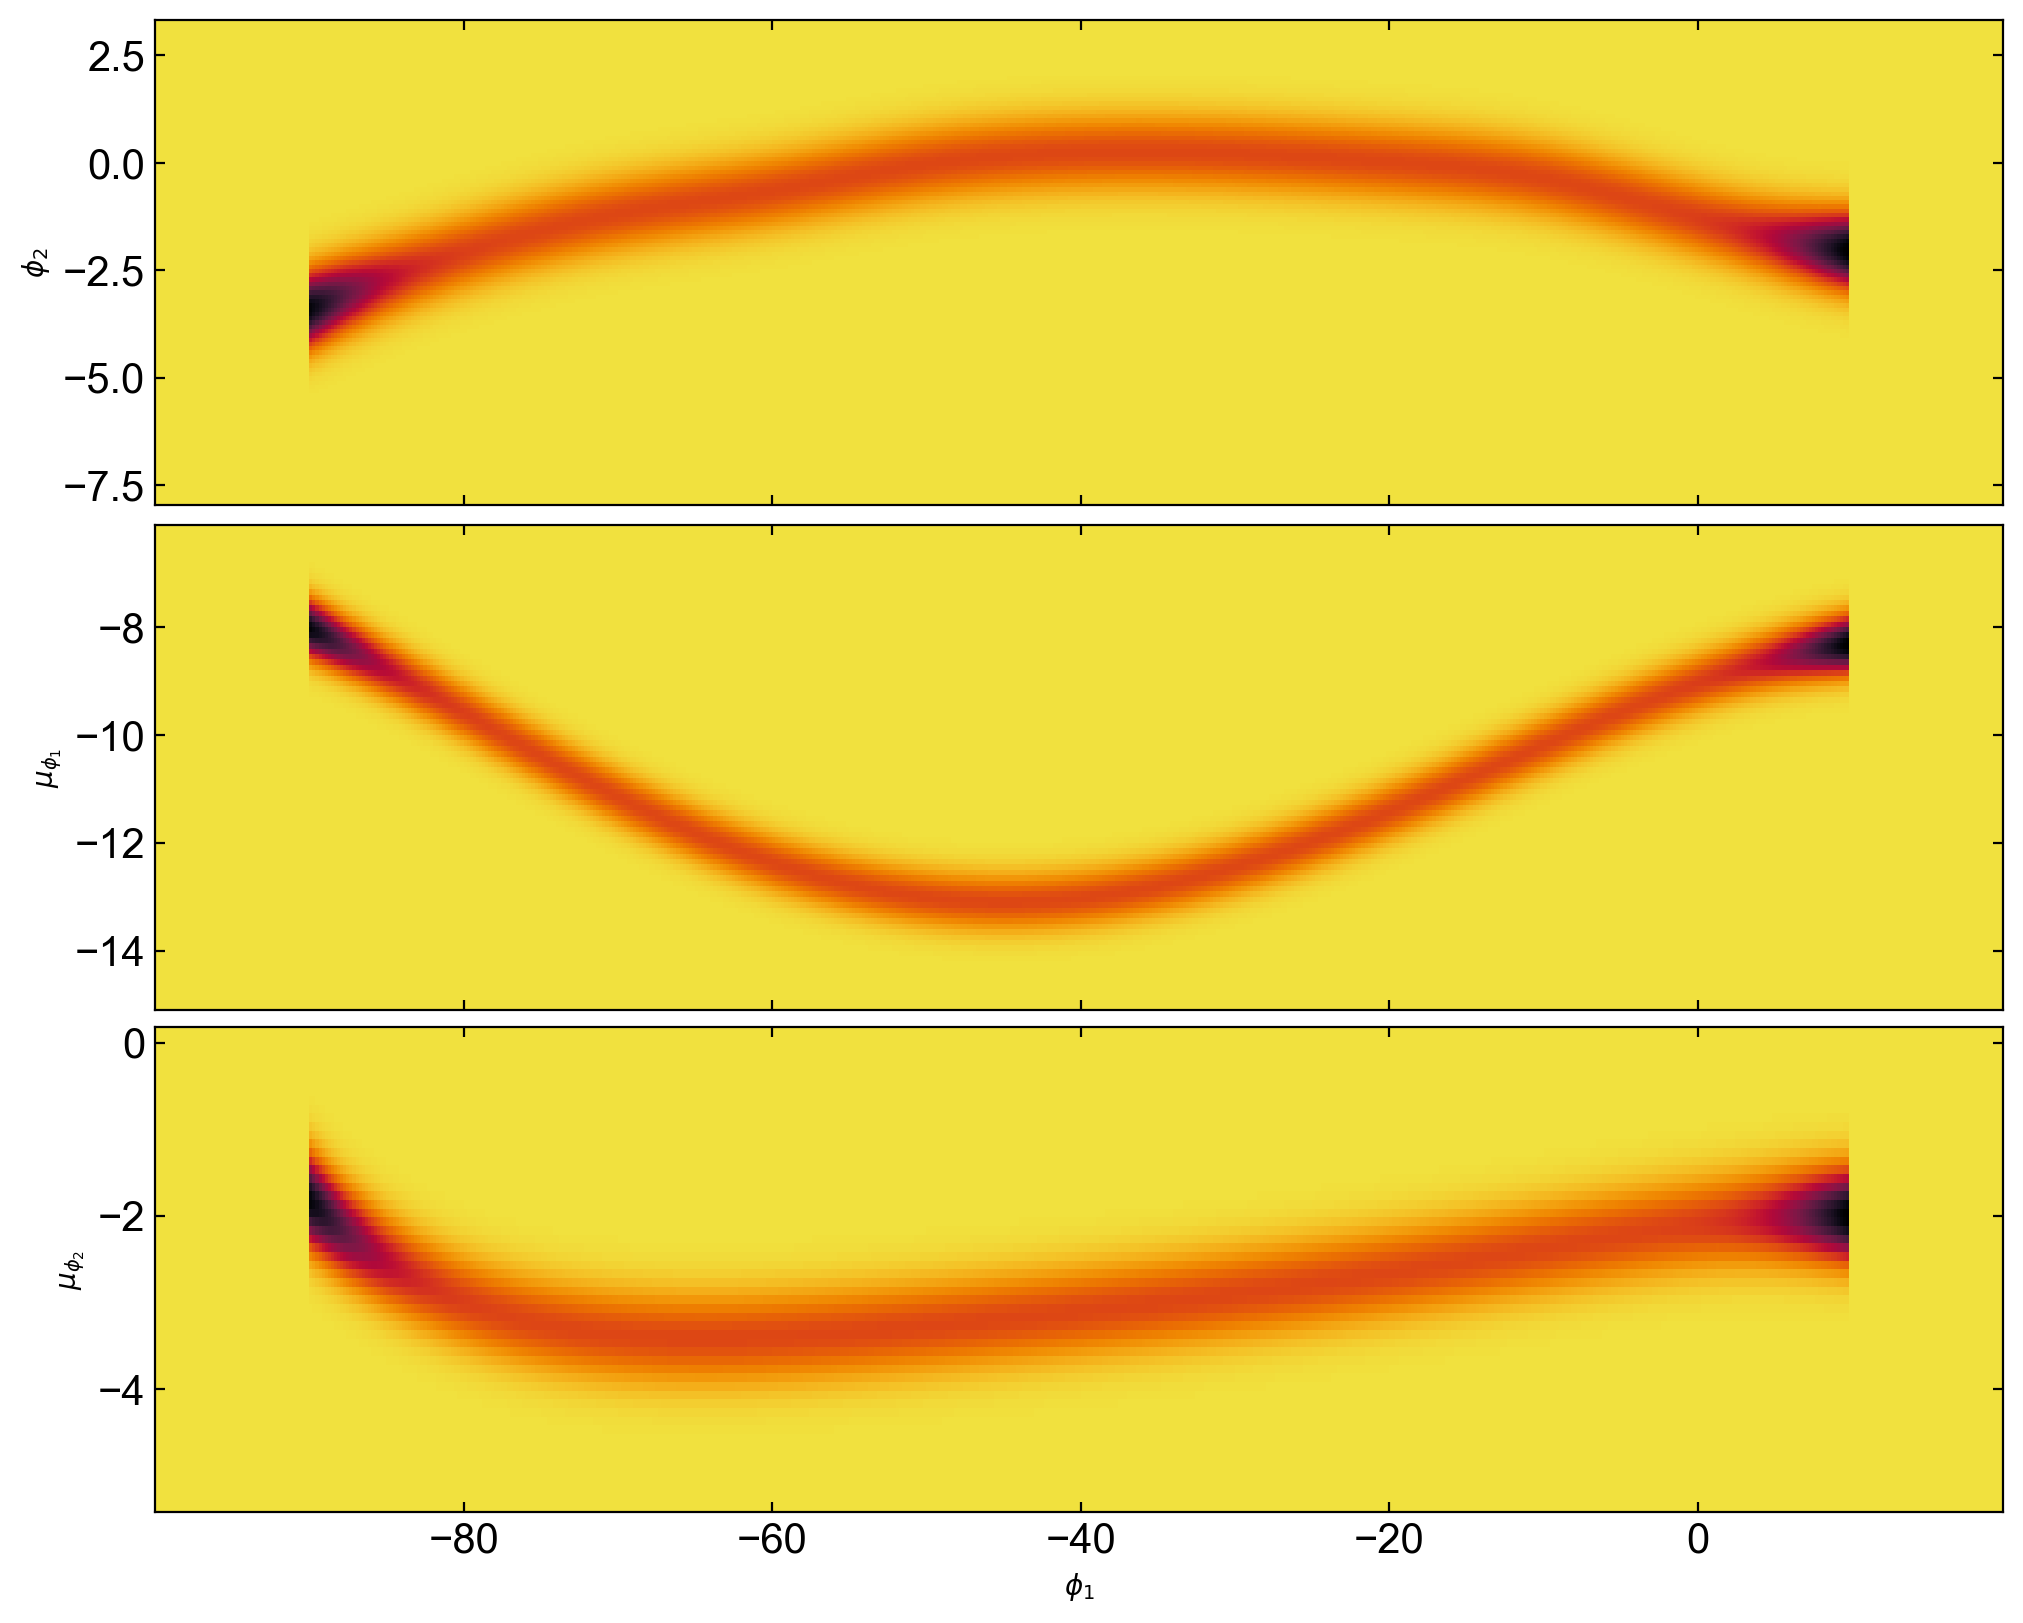

In [24]:
stream_init = StreamDensModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [25]:
stream_init_p

{'ln_N': 7.330405211844402,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-3.42311228, -2.10987155, -1.2022898 , -0.6577231 , -0.03946769,
          0.23196929,  0.2093434 ,  0.02200576, -0.36245683, -1.28793346,
         -2.04421317]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm1': {'mean': array([ -8.01001683,  -9.56759857, -11.13936588, -12.35797586,
         -13.01218256, -13.0285359 , -12.4530807 , -11.43305565,
         -10.19859231,  -9.04441407,  -8.319378  ]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-1.80139711, -2.9752413 , -3.37508727, -3.40032892, -3.27746152,
         -3.10639161, -2.90674685, -2.66418592, -2.37670834, -2.10096442,
         -1.99723637]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])}}

In [26]:
# stream_opt_pars, info = StreamDensModel.optimize(
#     data=stream_data, init_params=stream_init_p, use_bounds=True
# )

stream_opt_pars, info = optimize(StreamDensModel,
    data=stream_data, init_params=stream_init_p, use_bounds=True
)

stream_opt = StreamDensModel(stream_opt_pars)
info

INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 7.3966115213756e-12, Decrease error: 1.017761790561066e-11, Curvature error: 0.1376044675376198
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-09, Decrease error: 2.4702431186116073e-09, Curvature error: 0.13264410980128294
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-09, Decrease error: 4.248614096328239e-09, Curvature error: 0.2281291104054448
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-09, Decrease error: 4.648584304236408e-09, Curvature error: 0.24960451391484995
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-09, Decrease error: 5.33945365920161e-09, Curvature error: 0.28669899944581845
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-09, Decrease error: 5.632230203287831e-09, Curvature error: 0.3024189228778842
INFO: jaxopt.ZoomLineSearch: Iter: 30, Stepsize: 1.862645149230957e-09, Decrease error: 5.967555286823578e-09, Curvat

LbfgsbState(iter_num=Array(1024, dtype=int64, weak_type=True), value=Array(-0.39128375, dtype=float64), grad={'ln_N': Array(0.01135533, dtype=float64), 'phi1': {'zs': Array([ 0.02795656,  0.02715313,  0.02518552,  0.02257122,  0.02081237,
        0.02047872,  0.02096062,  0.01994673,  0.01478542,  0.00520162,
       -0.0071507 , -0.01810802, -0.01681305, -0.01040709, -0.00990475,
       -0.01496021, -0.01961773, -0.01356209, -0.00614986, -0.01243449,
       -0.02666018, -0.02077379, -0.01557774, -0.01994939, -0.01585707,
       -0.00627423, -0.00138206], dtype=float64)}, 'phi2': {'ln_std': Array([ 0.0034405 ,  0.01489946,  0.01608749,  0.04835219,  0.05741185,
        0.02725991,  0.02395679,  0.03833716,  0.04711571,  0.0459381 ,
       -0.00021351], dtype=float64), 'mean': Array([-3.76644767e-03,  1.35803874e-05,  6.40518457e-03, -1.53161491e-03,
       -2.36146948e-03,  1.65702047e-03,  1.73801568e-03, -1.07188910e-03,
       -4.03728439e-03,  1.69226819e-03, -5.50176489e-03], dtype

Text(0, 0.5, '$\\phi_2$')

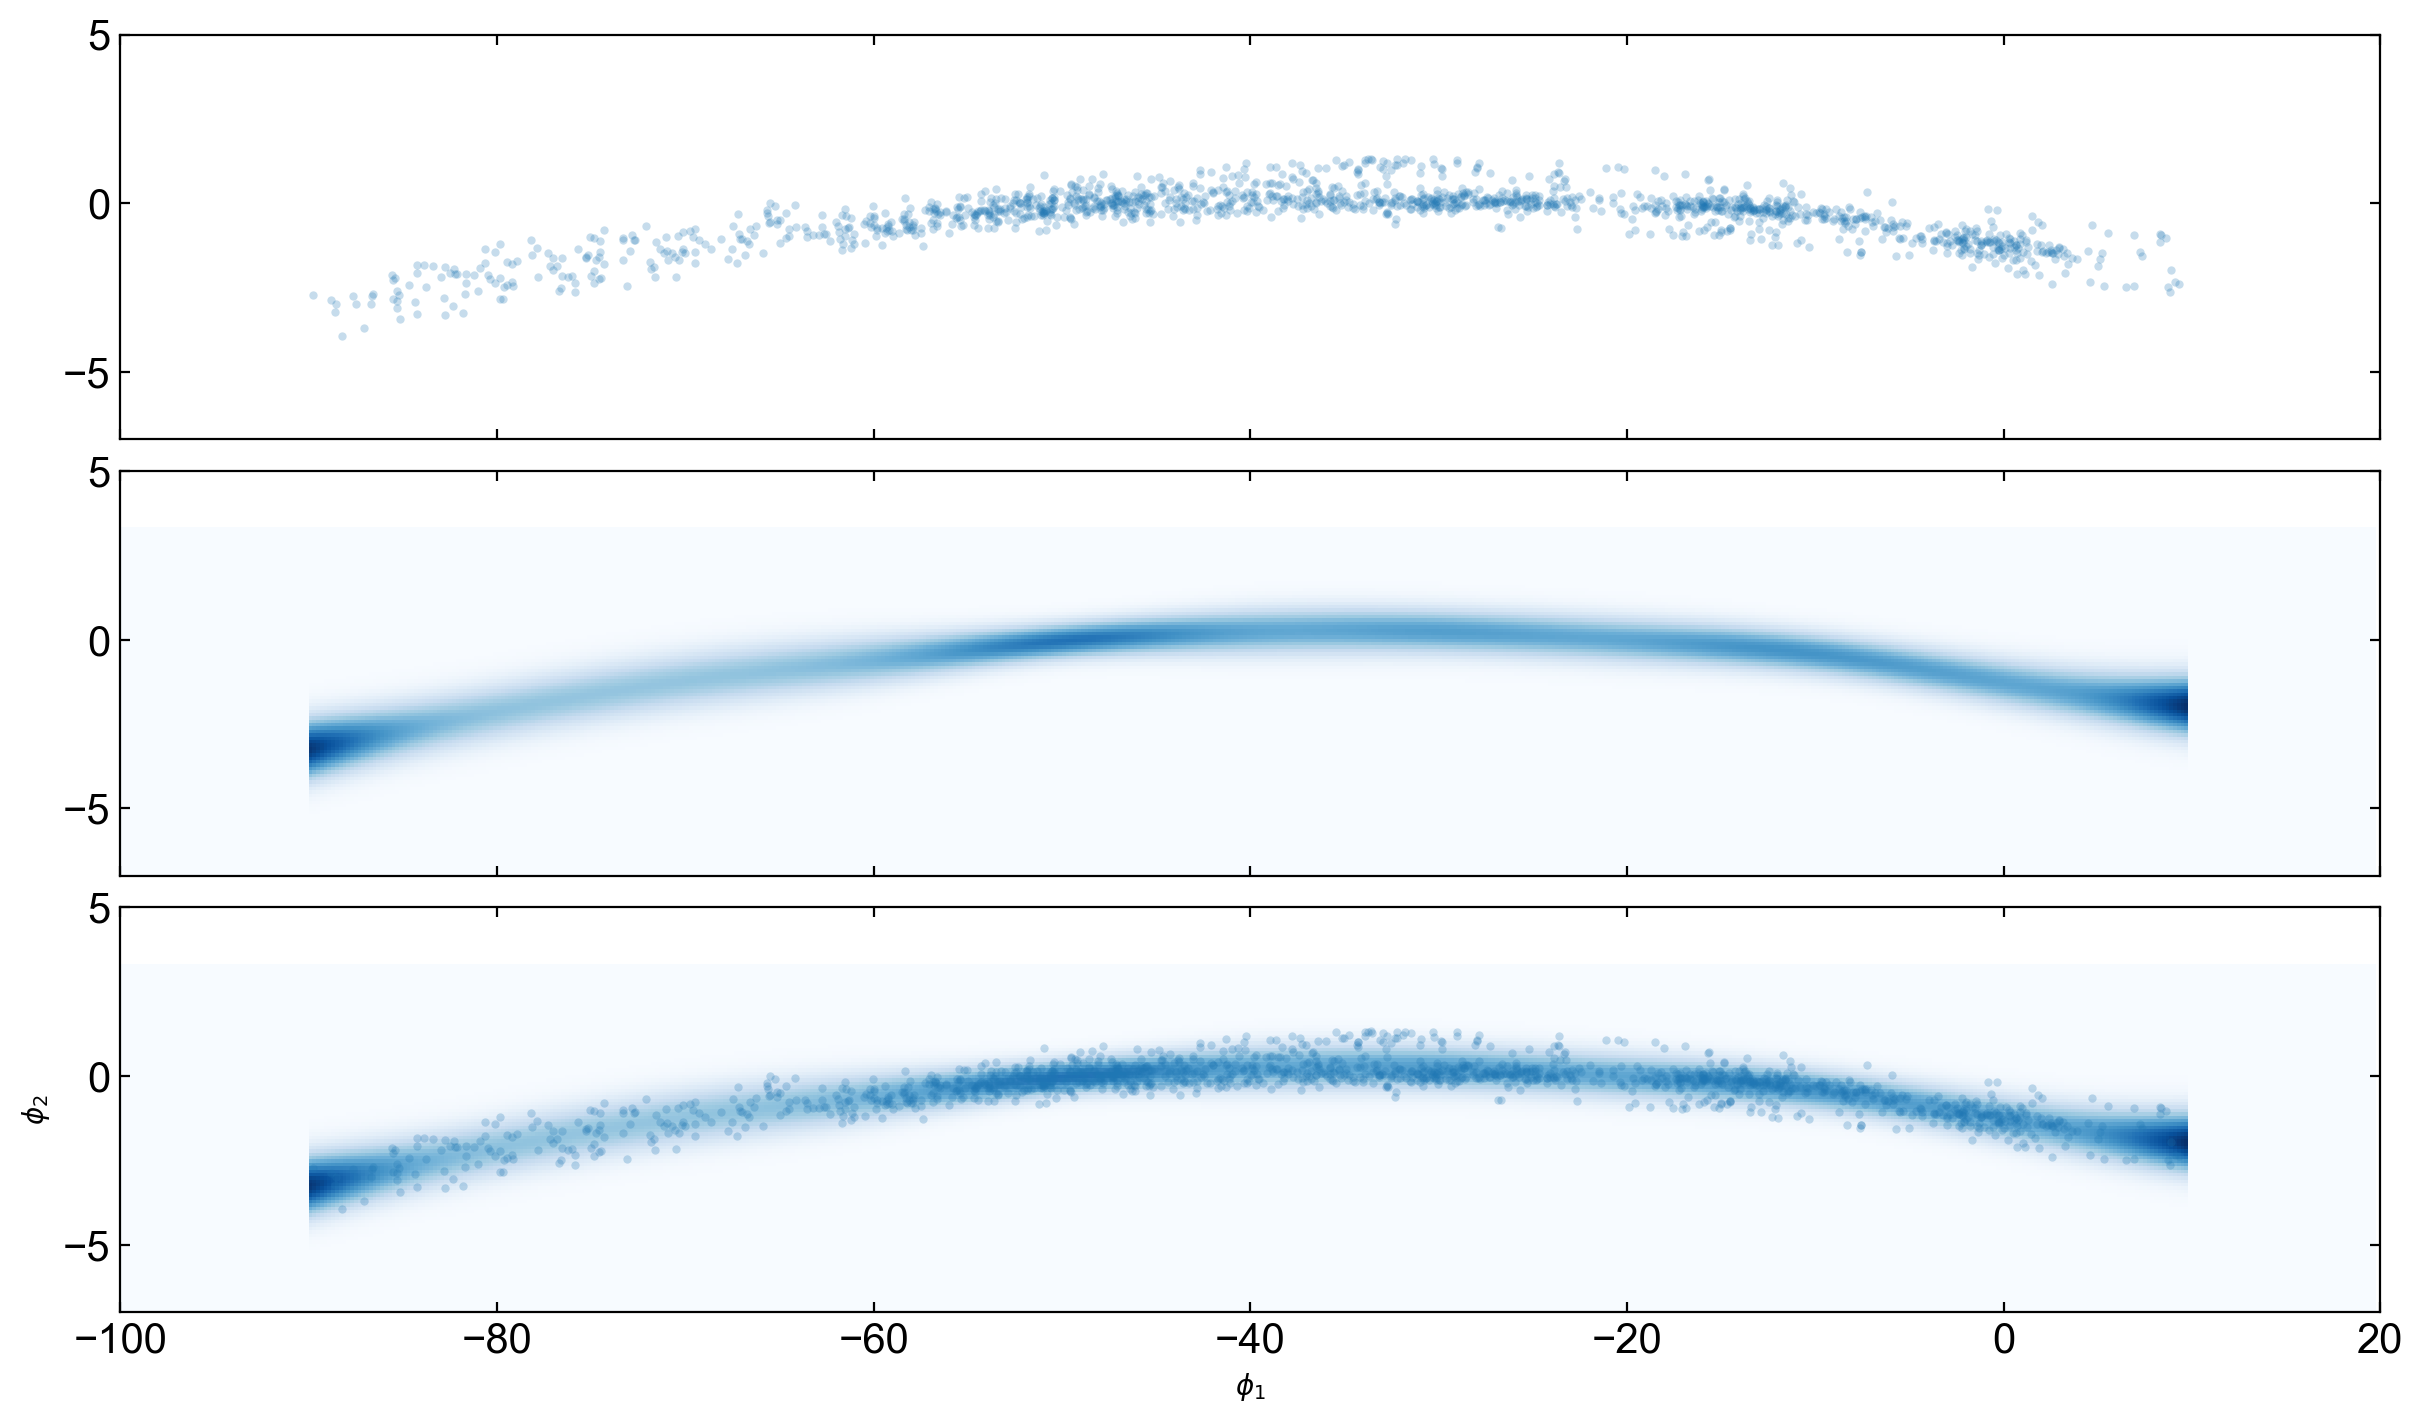

In [27]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

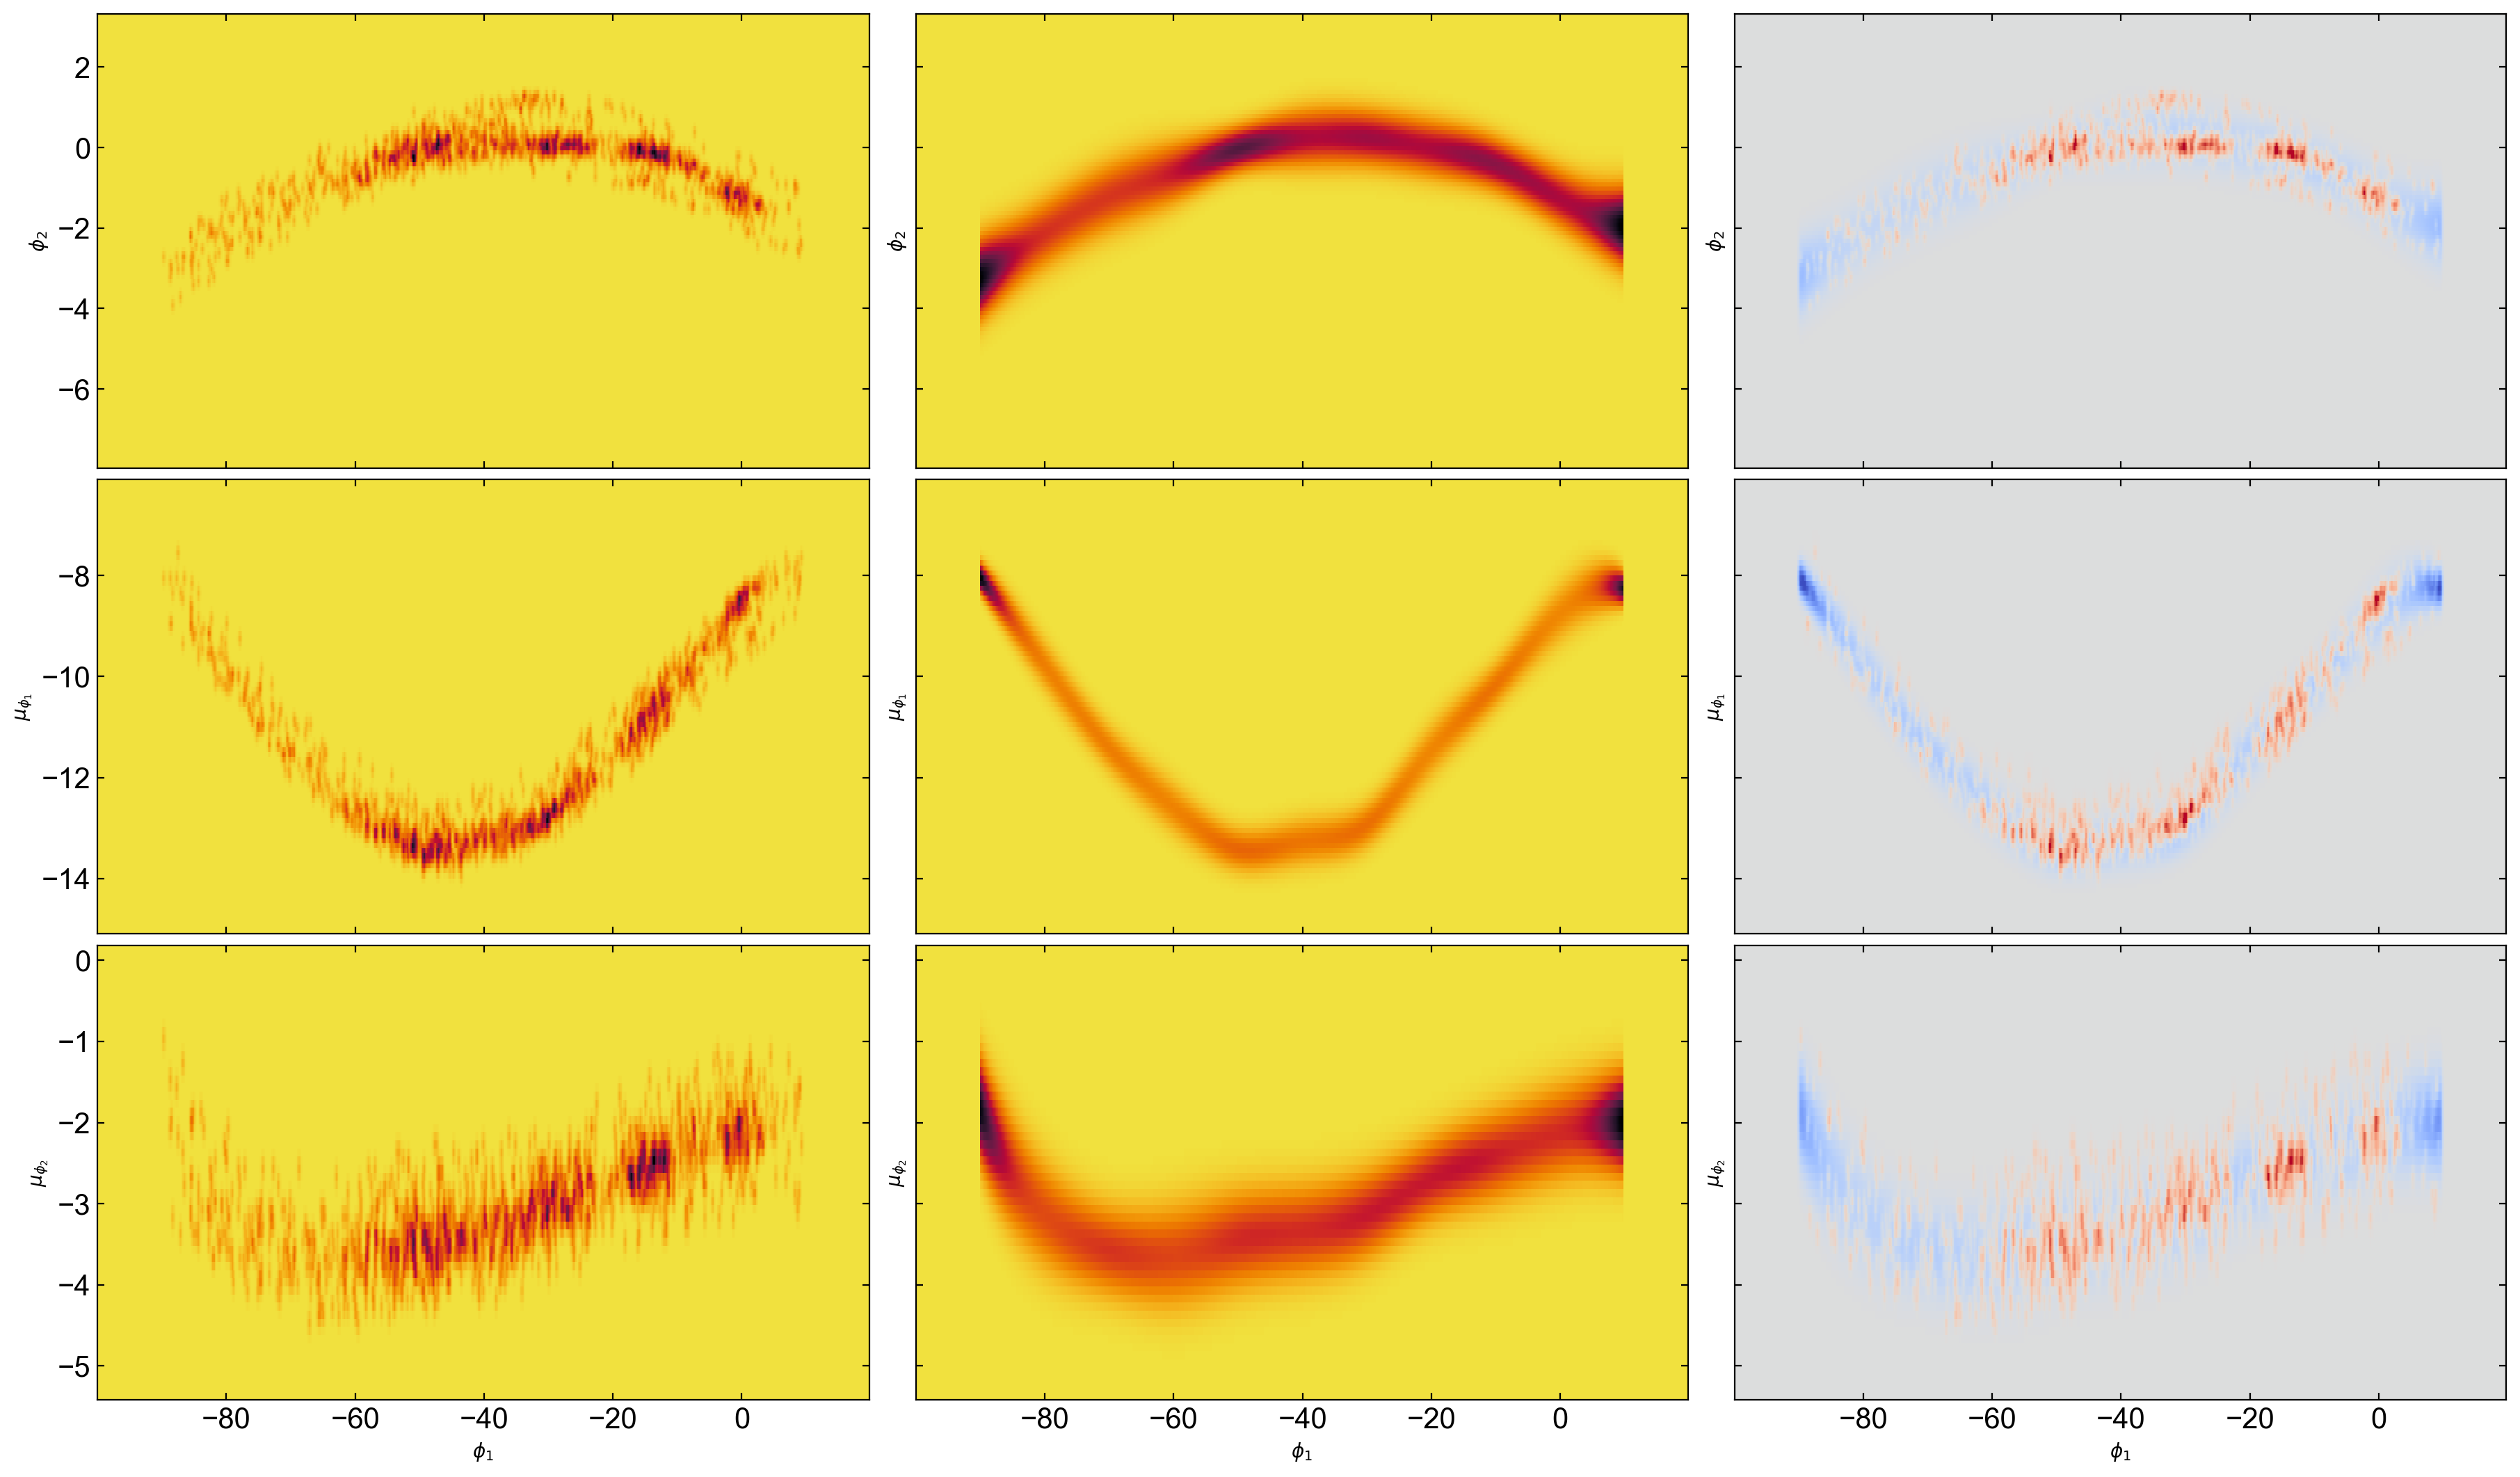

In [28]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [29]:
Components = [StreamDensModel, BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [30]:
mix_init = StreamMixtureModel(mix_params0, Components)

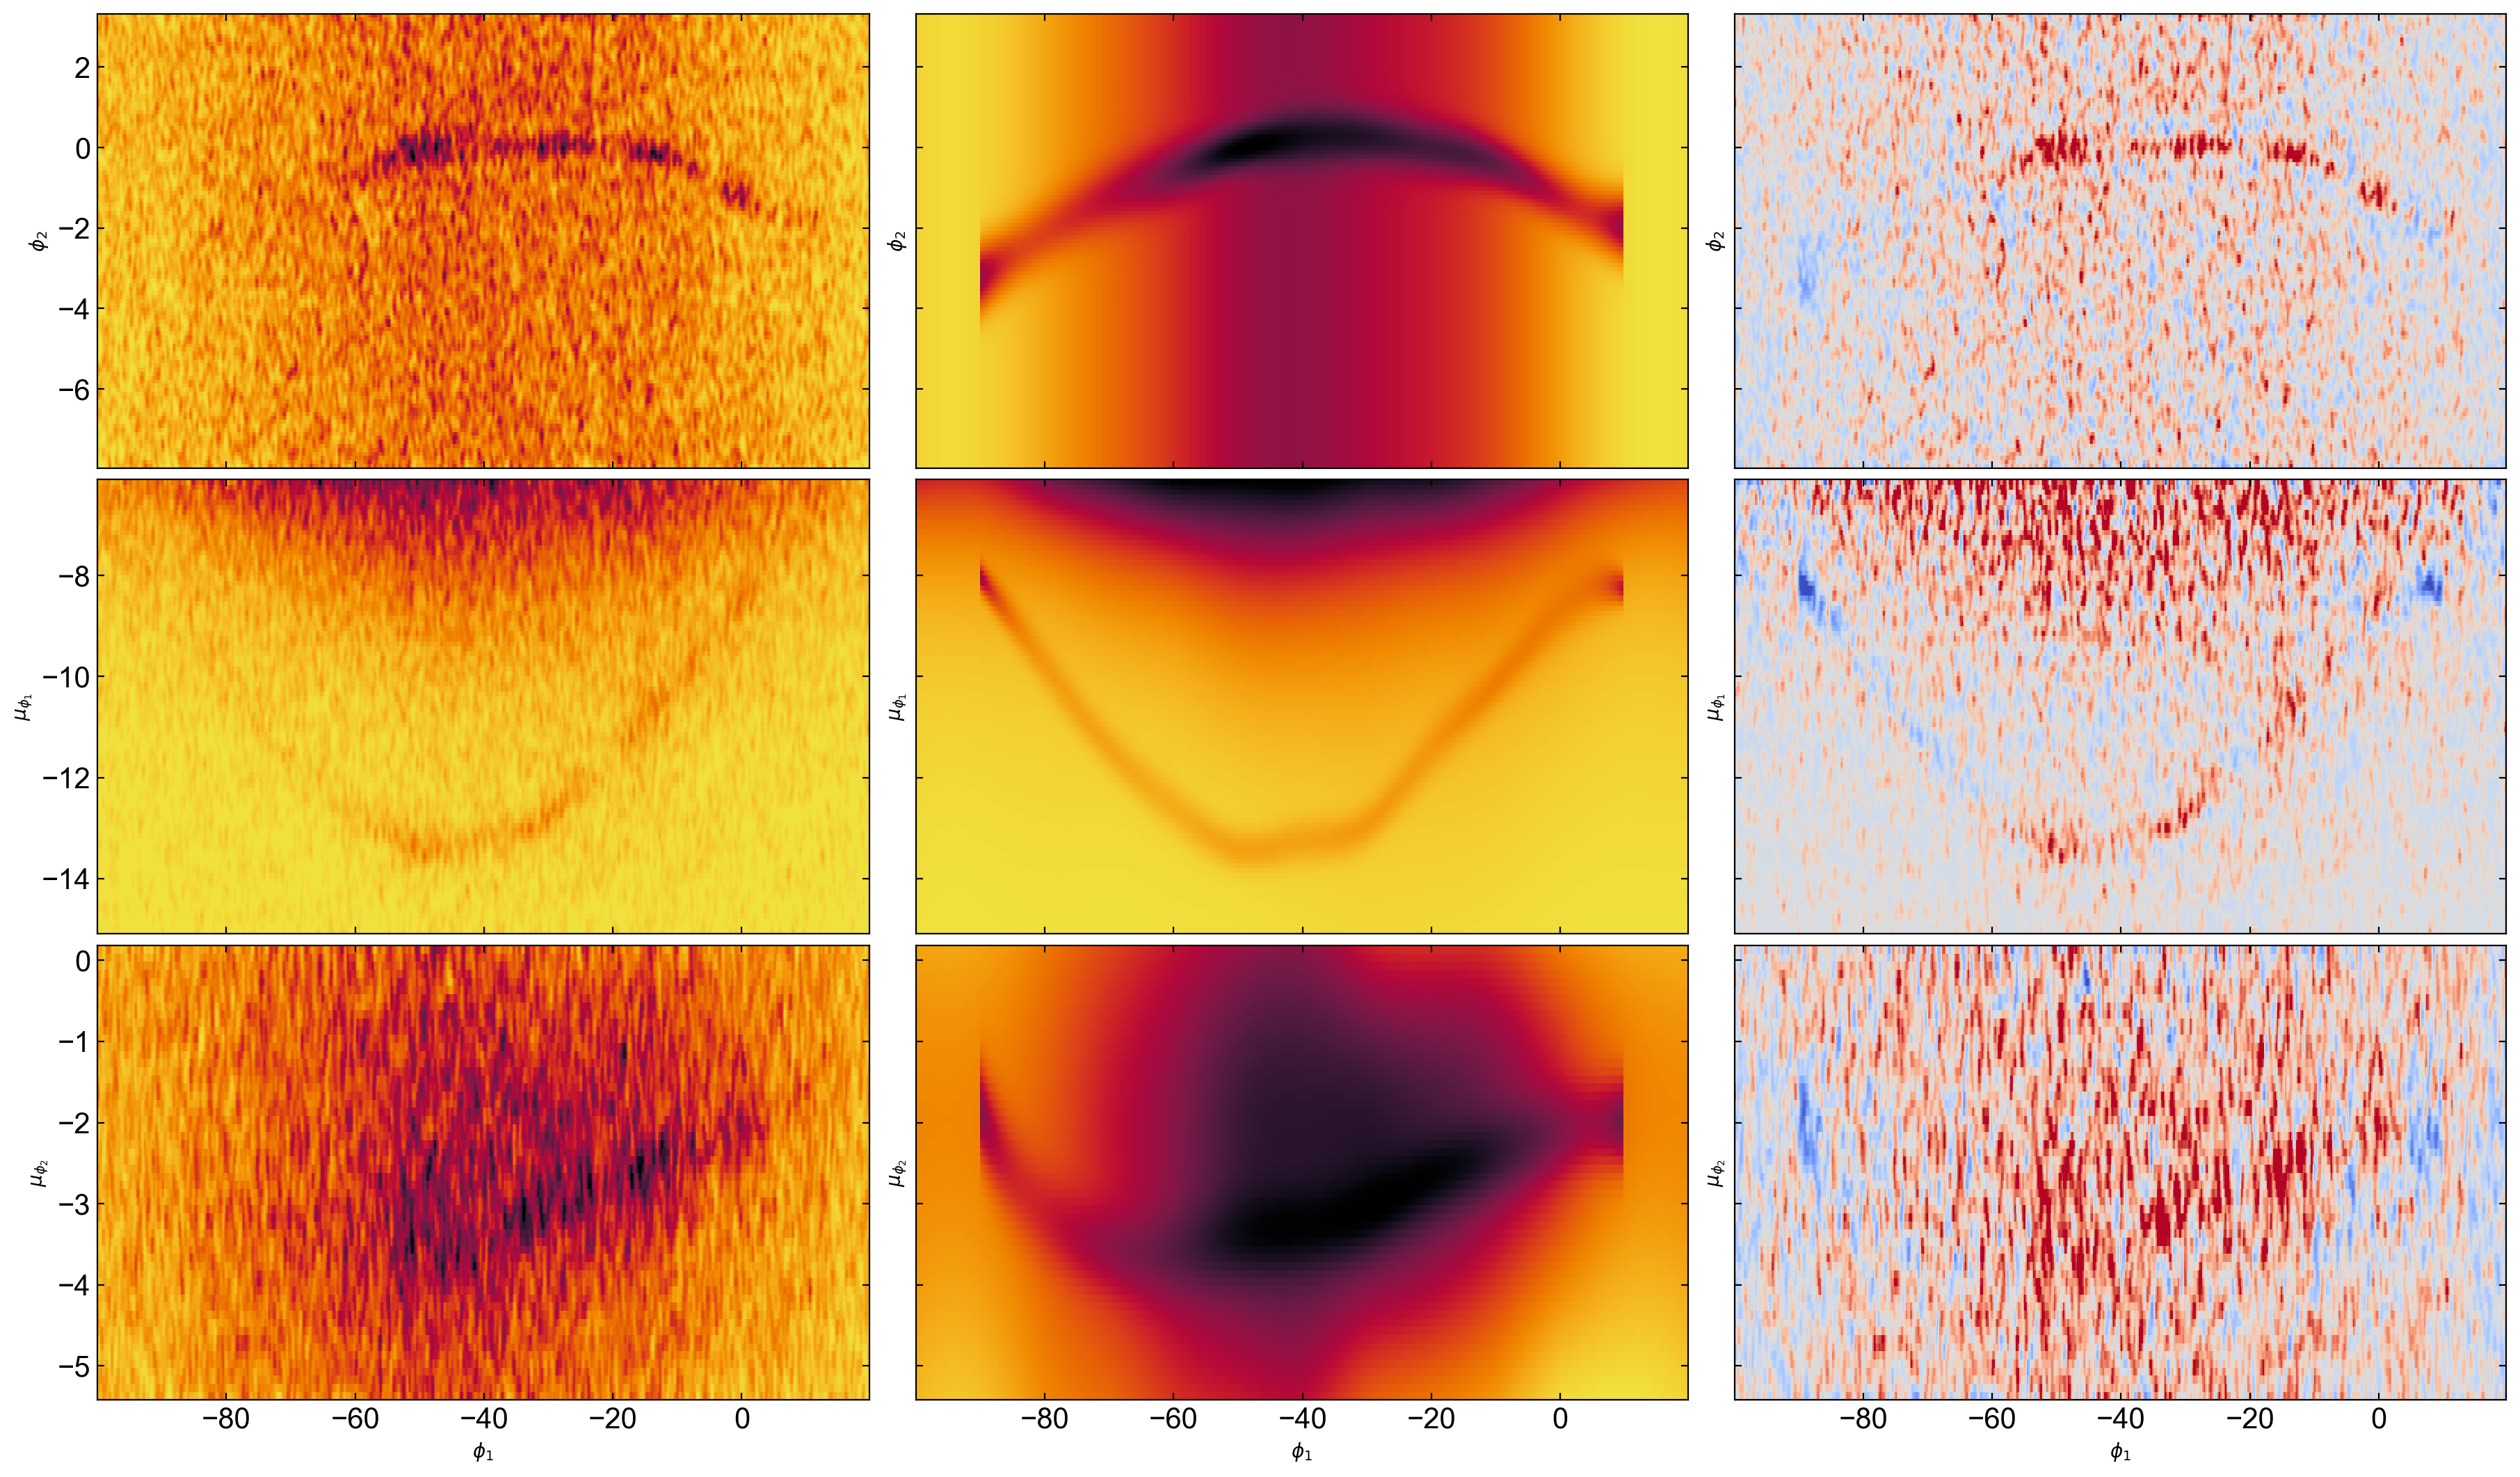

In [31]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [32]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(nan, dtype=float64, weak_type=True), success=False, status=2, iter_num=18, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]), num_fun_eval=Array(34, dtype=int32), num_jac_eval=Array(34, dtype=int32), num_hess_eval=Array(0, dtype=int32))

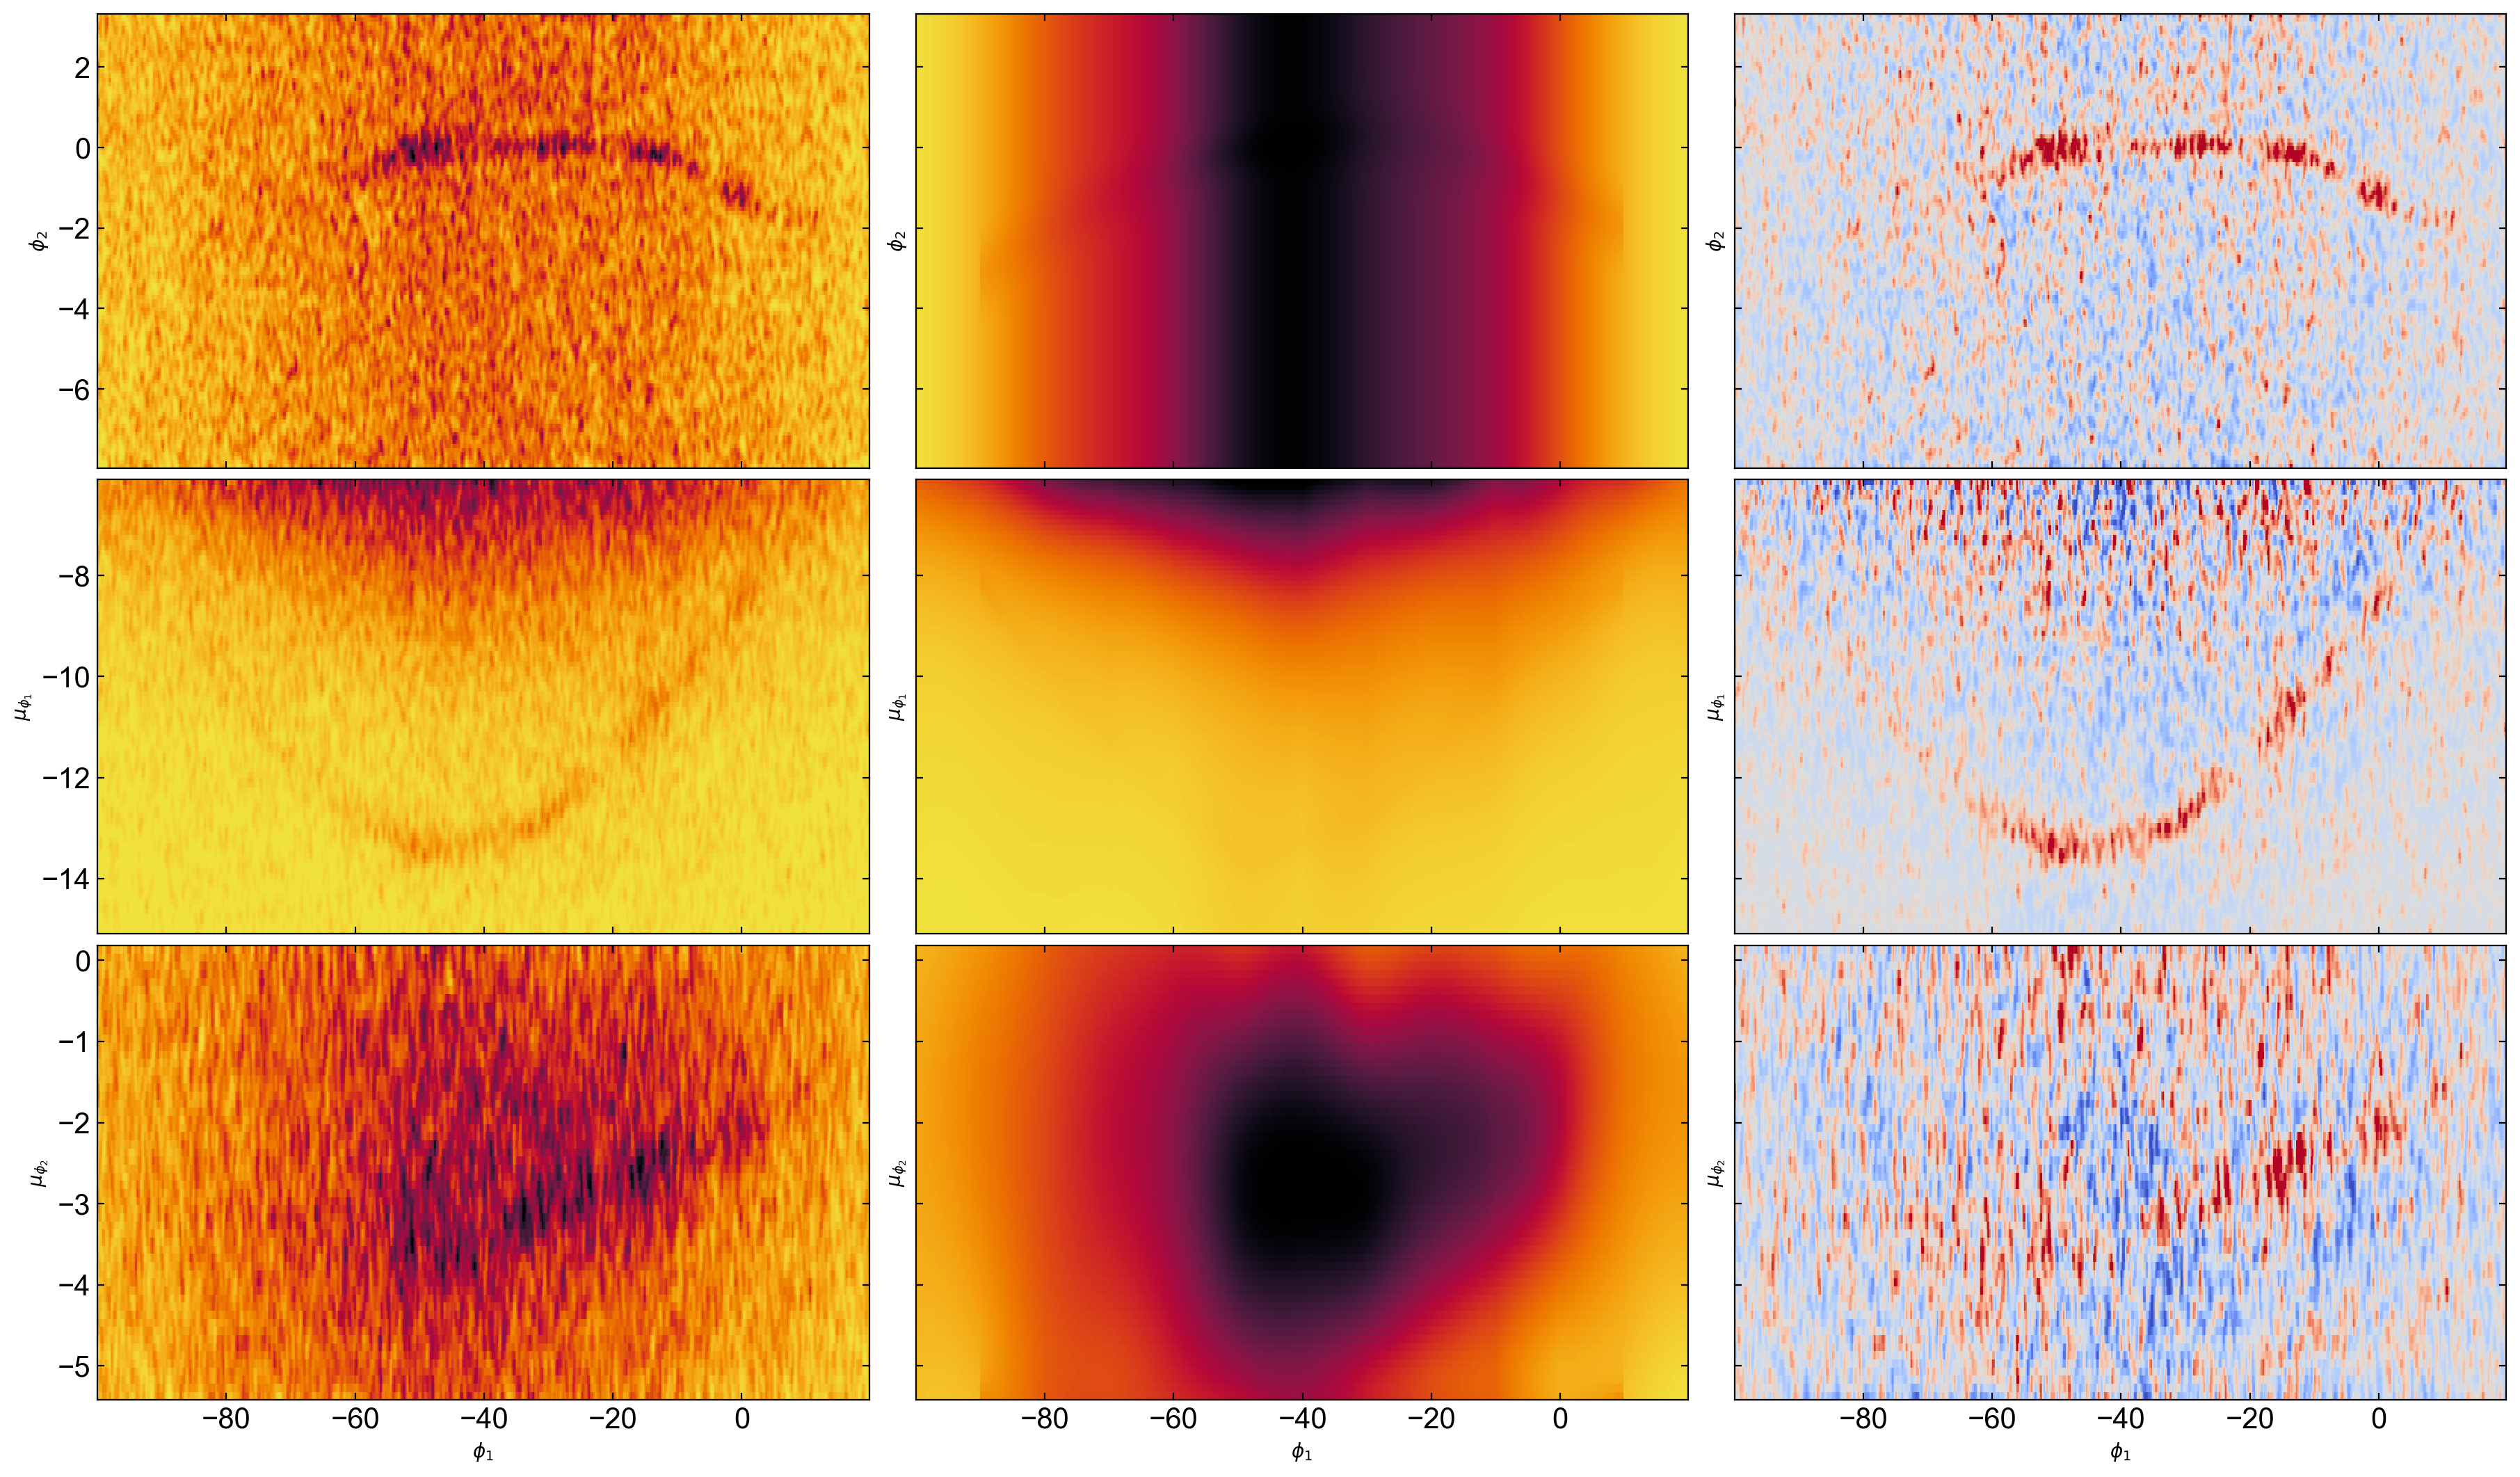

In [33]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [34]:
OffTrackModel.offtrack_update(p, cat)

In [35]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

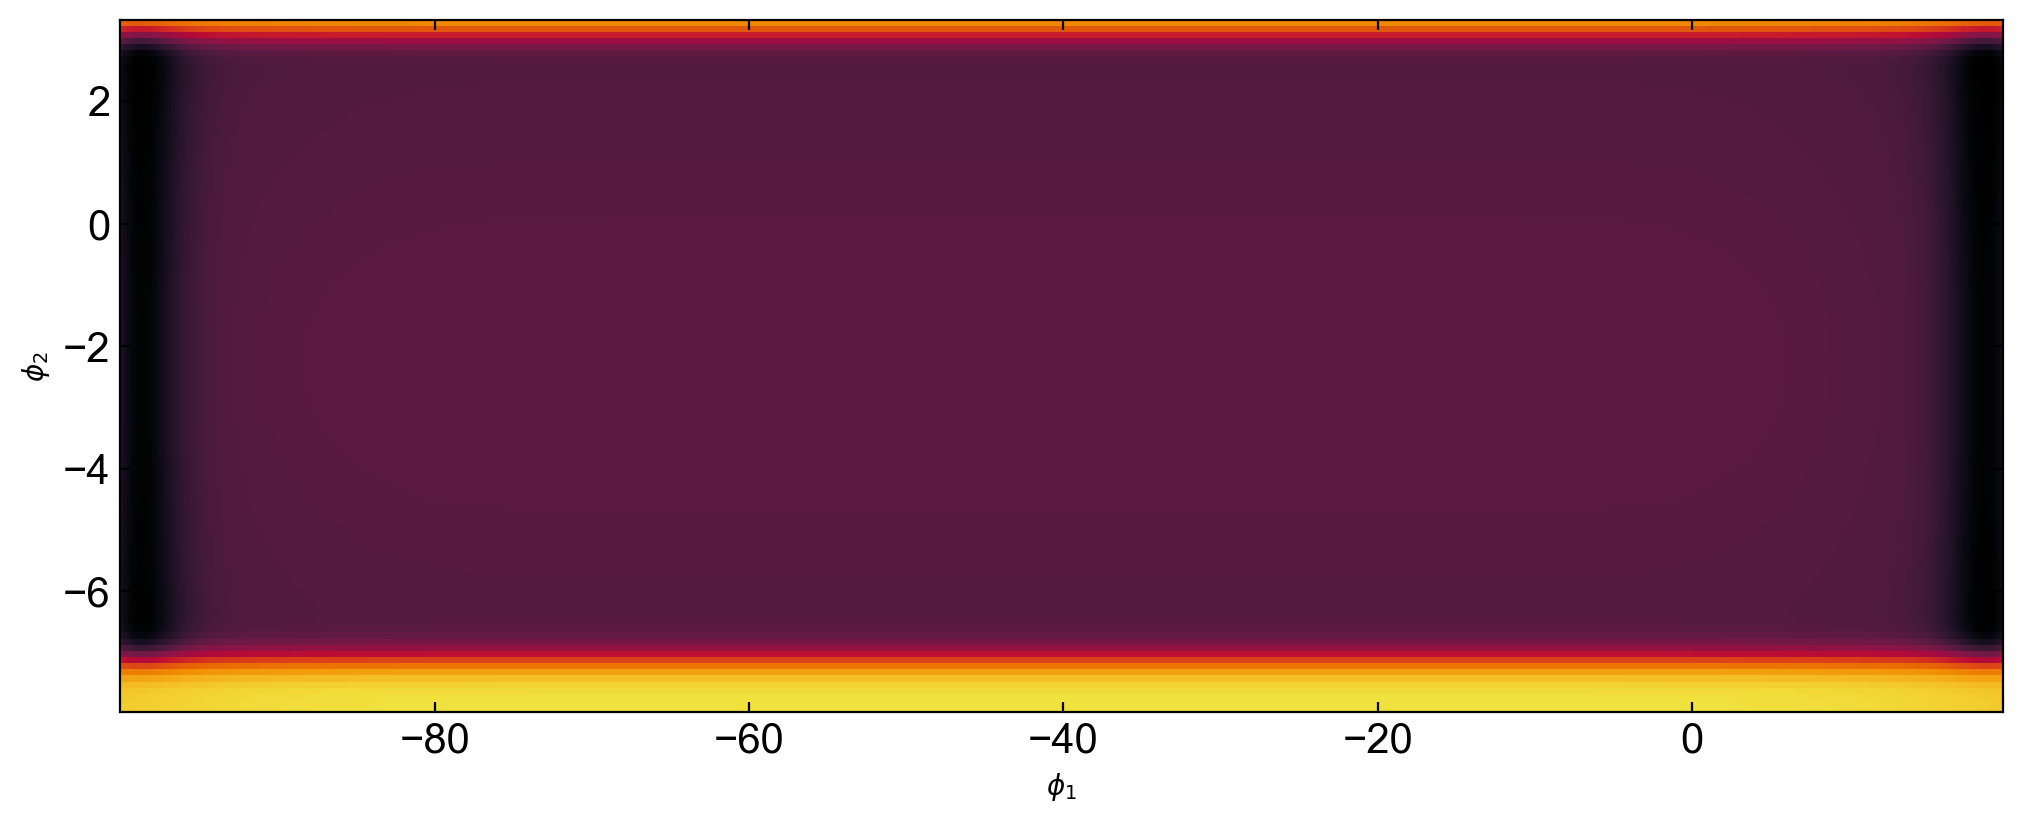

In [36]:
offtrack_model0 = OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [37]:
full_Components = [StreamDensModel, BackgroundModel, OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [38]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [39]:
full_mix_params0['offtrack'][('phi1', 'phi2')]['zs'].shape

(2578,)

In [ ]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    #tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

In [53]:
# if optimization fails, run again with initialization from the end of the last run

full_mix_params1 = full_mix_opt_pars

full_mix_opt_pars1, info1 = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    #tied_params=tied_params,
    init_params=full_mix_params1,
    use_bounds=True,
)
full_mix_opt1 = StreamMixtureModel(full_mix_opt_pars1, Components=full_Components)
info1

ScipyMinimizeInfo(fun_val=Array(0.88303384, dtype=float64, weak_type=True), success=True, status=0, iter_num=14, hess_inv=LbfgsInvHessProduct(sk=[[-2.14346442e-05 -1.23278657e-06 -2.33501326e-05 ...  8.33768086e-06
  -1.22883901e-05  1.78778769e-04]
 [-5.43794168e-05 -9.25632158e-07 -1.90064393e-05 ... -3.53922799e-05
  -7.31511696e-05  1.34189541e-04]
 [-5.75320863e-05 -9.81813598e-07 -1.92284832e-05 ... -1.02317788e-04
  -1.80460673e-04  1.46310531e-04]
 ...
 [ 3.92493089e-05 -5.16648533e-07 -6.14123277e-06 ...  6.92638295e-05
   9.43887786e-05  7.67024358e-05]
 [-4.22070761e-06 -6.95564738e-07 -1.01192947e-05 ...  7.29867583e-05
   9.72312151e-05  1.01823898e-04]
 [ 1.49404294e-05 -2.09012654e-06 -4.19751359e-05 ...  8.41100074e-05
   9.22854412e-05  2.97384380e-04]], yk=[[-2.07396672e-05 -5.13343328e-09 -6.53059179e-07 ... -4.98626667e-07
  -2.98268283e-07  6.15168137e-08]
 [-5.22713106e-05 -5.90219090e-09 -8.22238701e-07 ... -2.92583662e-06
  -4.00289625e-06  7.63542389e-08]
 [-5.

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

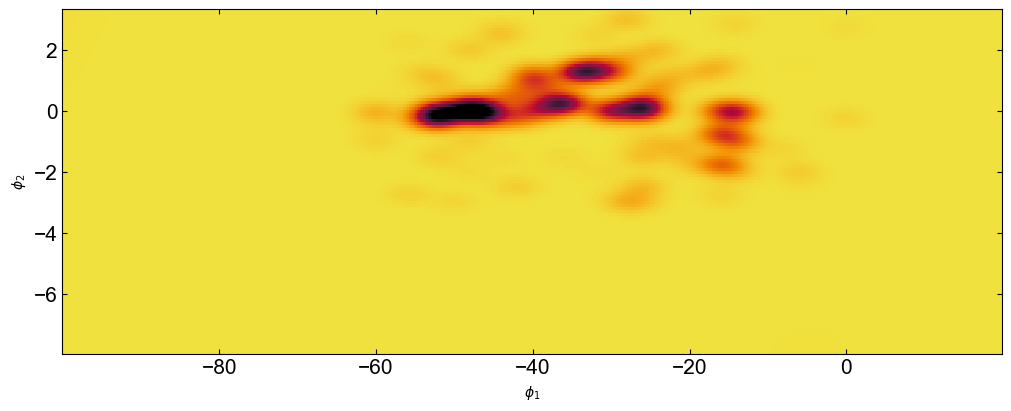

In [55]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars1['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars1['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars1['stream']['pm2'].copy()
tmp = OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='cmr.ember_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

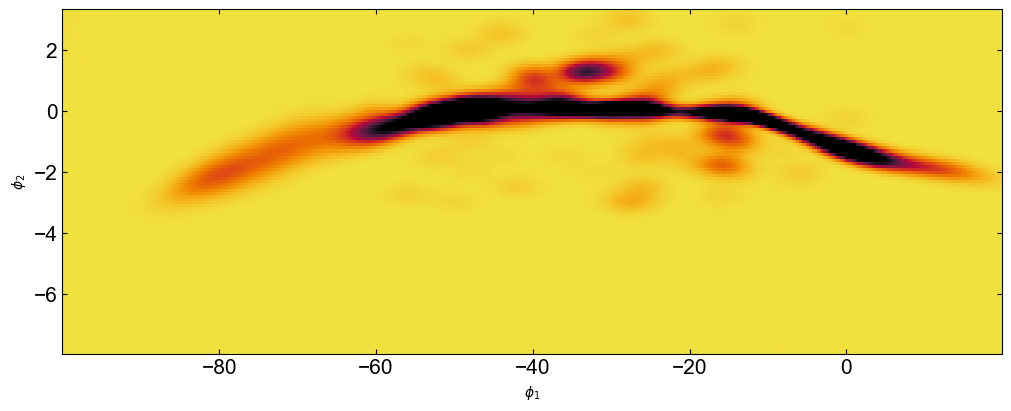

In [58]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars1, Components=[StreamDensModel, OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='cmr.ember_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

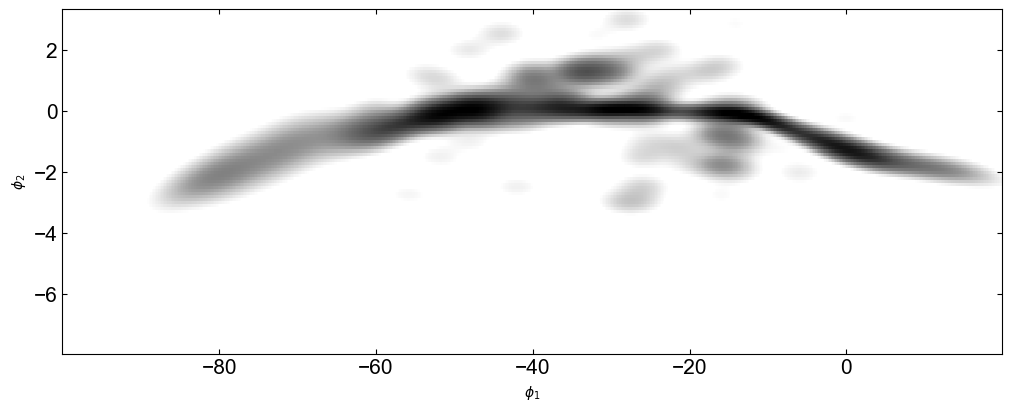

In [60]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars1, Components=[StreamDensModel, OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

(<Figure size 800x1000 with 3 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>, <Axes: ylabel='$\\mu_{\\phi_1}$'>,
        <Axes: xlabel='$\\phi_1$', ylabel='$\\mu_{\\phi_2}$'>],
       dtype=object))

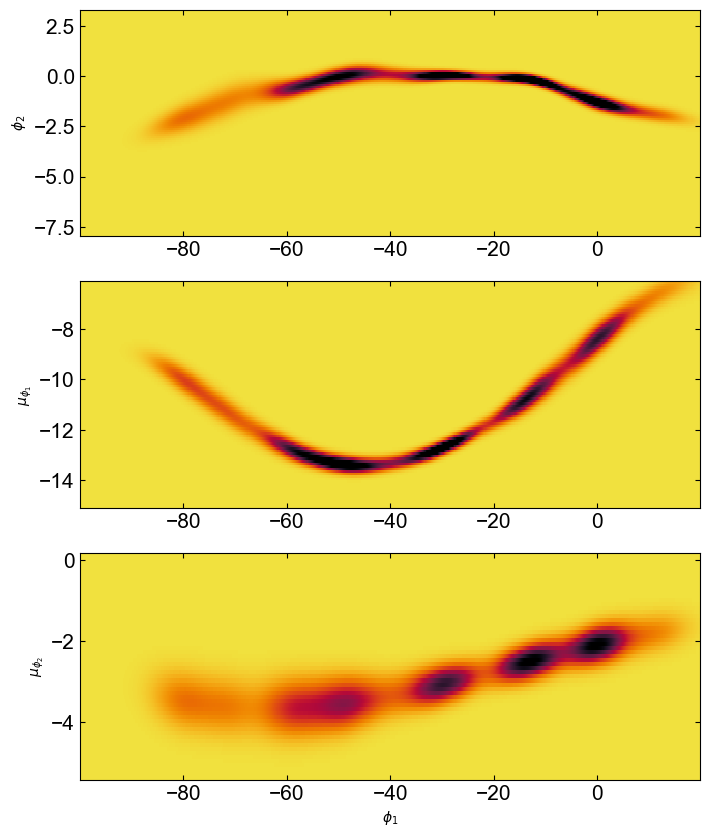

In [78]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_stream_opt1 = StreamDensModel(full_mix_opt_pars1['stream'])
full_stream_opt1.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

In [79]:
full_mix_opt_pars1['stream']

{'ln_N': Array(7.00673518, dtype=float64),
 'phi1': {'zs': Array([-5.25005794e+00, -6.82170567e+00, -7.96718585e+00, -8.00000000e+00,
         -8.00000000e+00, -5.46360482e+00,  5.91634401e-01, -5.20591019e+00,
          2.84470472e-01, -9.19685982e-01, -3.80695338e+00,  7.54213643e-01,
          2.66042833e-01,  6.35667958e-03,  1.21192886e+00, -3.81130446e+00,
          1.44444779e-01, -6.93640022e+00,  7.83484156e-01,  1.01560214e+00,
         -7.84365486e+00, -8.00000000e+00,  4.26733878e-01,  1.67588687e+00,
         -7.47337613e+00, -5.61721759e+00,  3.15145233e+00, -5.35023332e+00,
          9.14032794e-01,  8.00000000e+00,  2.55519809e+00,  5.77327192e-01],      dtype=float64)},
 'phi2': {'ln_std': Array([-0.90317582, -0.89821961, -0.88355554, -0.72199009, -0.76826228,
         -1.20698427, -1.38420301, -1.40796492, -1.64079325, -1.98985564,
         -1.940226  , -1.96837596, -1.62663185, -1.55785735, -1.4849805 ,
         -1.47106277], dtype=float64),
  'mean': Array([-3.15555

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

KeyError: 'phi1'

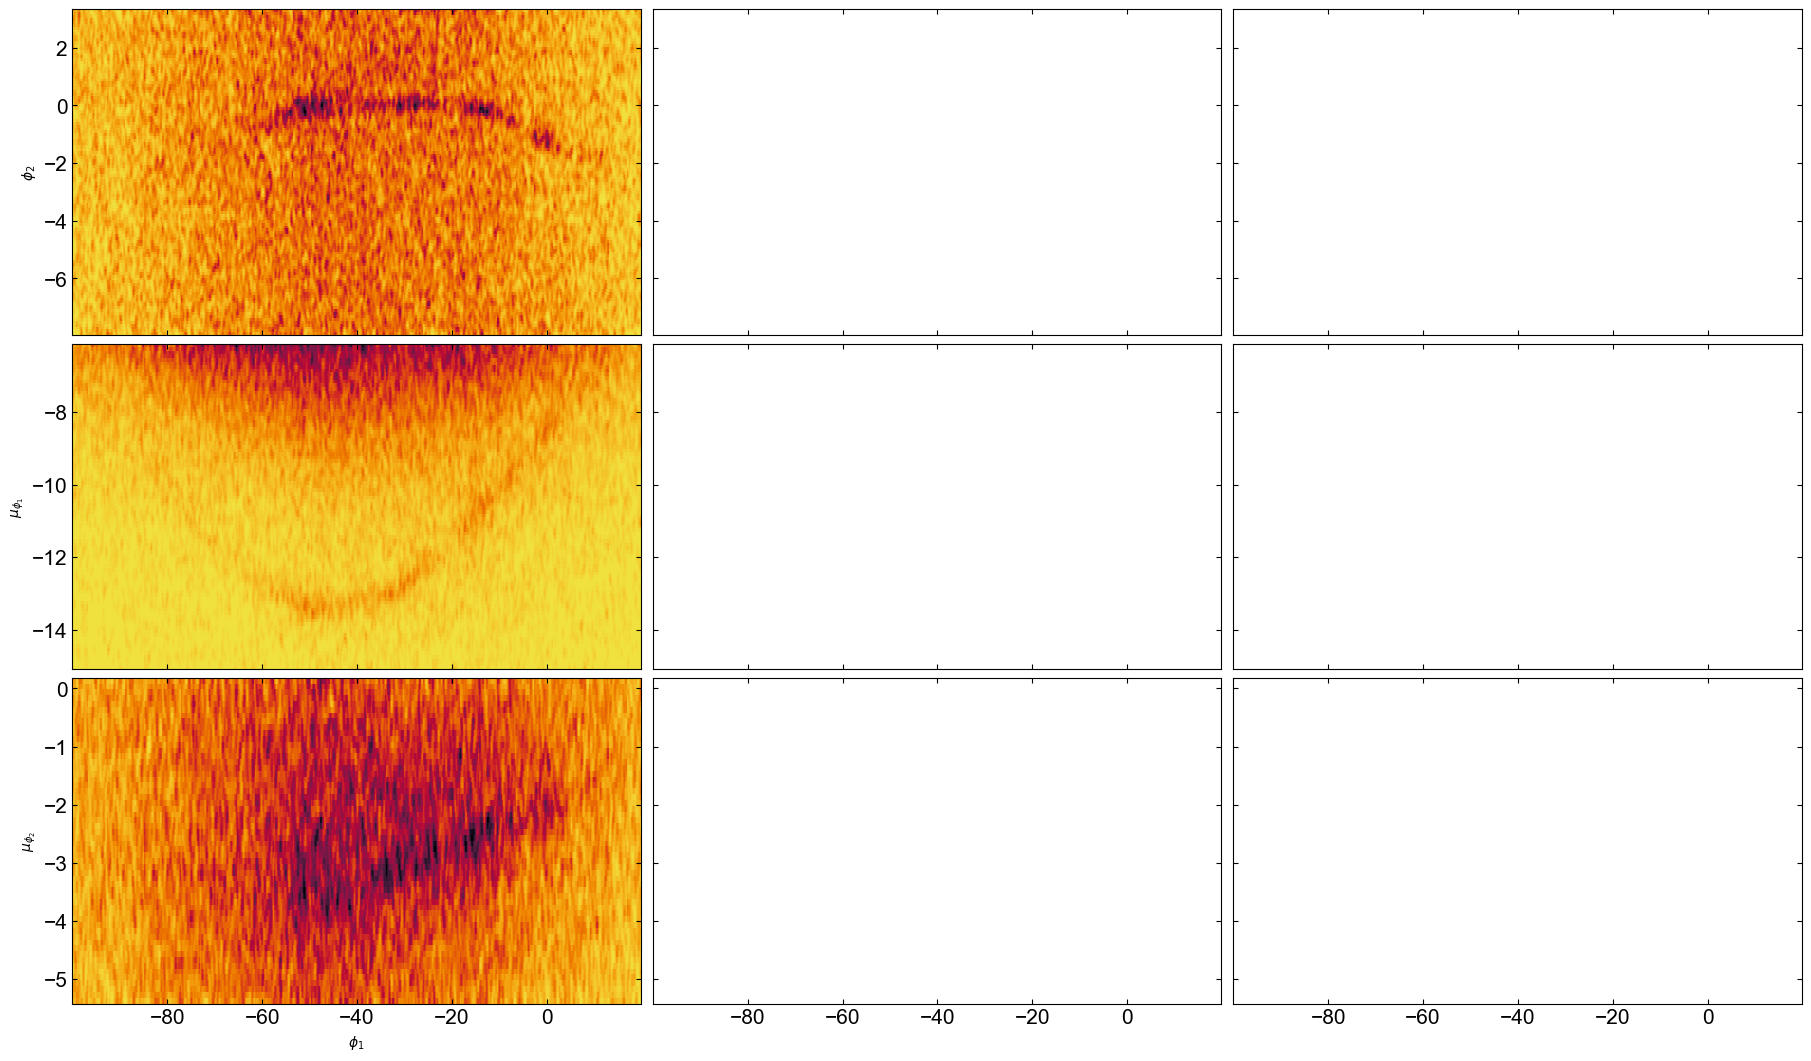

In [81]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)


axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt1.plot_model_projections(axes=axes[:, 1])
full_mix_opt1.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")